In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib import colormaps
from src.models.NSI import NSI
from src.models.channel import *
from src.models.continuous_models import *
from tqdm.notebook import tqdm
import pickle
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy import stats
from scipy.interpolate import interp1d
from collections import defaultdict
import numpy as np
import numpy.typing as npt
import networkx as nx
import matplotlib
import seaborn as sns
from collections.abc import Callable
from scipy.optimize import minimize, curve_fit

In [10]:

N = 10000
T = 1000
beta = 0.01
k = 4
num_runs = 100


In [11]:
## Errors

lin_errors = np.linspace(0,1,21)
log_errors = np.logspace(-10,0,11)
all_errors = np.concatenate([lin_errors, log_errors])
all_errors = np.unique(all_errors)

G = nx.barabasi_albert_graph(n=24, m=2)
M = nx.adjacency_matrix(G).todense()

channel_mapping = {
    
    'bin_sym': {err: single_flip_channel(1, err) for err in all_errors},
    'triangle': {err: simplex_channel(3, err) for err in all_errors},
    'cherry': {err: star_channel(3, err) for err in all_errors},
    'paw': {err: paw_channel(err) for err in all_errors},
    'bin_asym': {err: bin_asym_channel(0.1, np.abs(0.1 - err)) for err in all_errors},
    
}


"""
channel_mapping = {'bin_sym': {err: single_flip_channel(1, err) for err in [0.1, 0.65]},
                  'triangle': {err: simplex_channel(3, err) for err in [0.1, 0.65]}}

"""
num_errors = len(all_errors)
num_channels = len(channel_mapping.keys())

colors = ['crimson', 'lightsteelblue', 'moccasin', 'lightgreen']


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

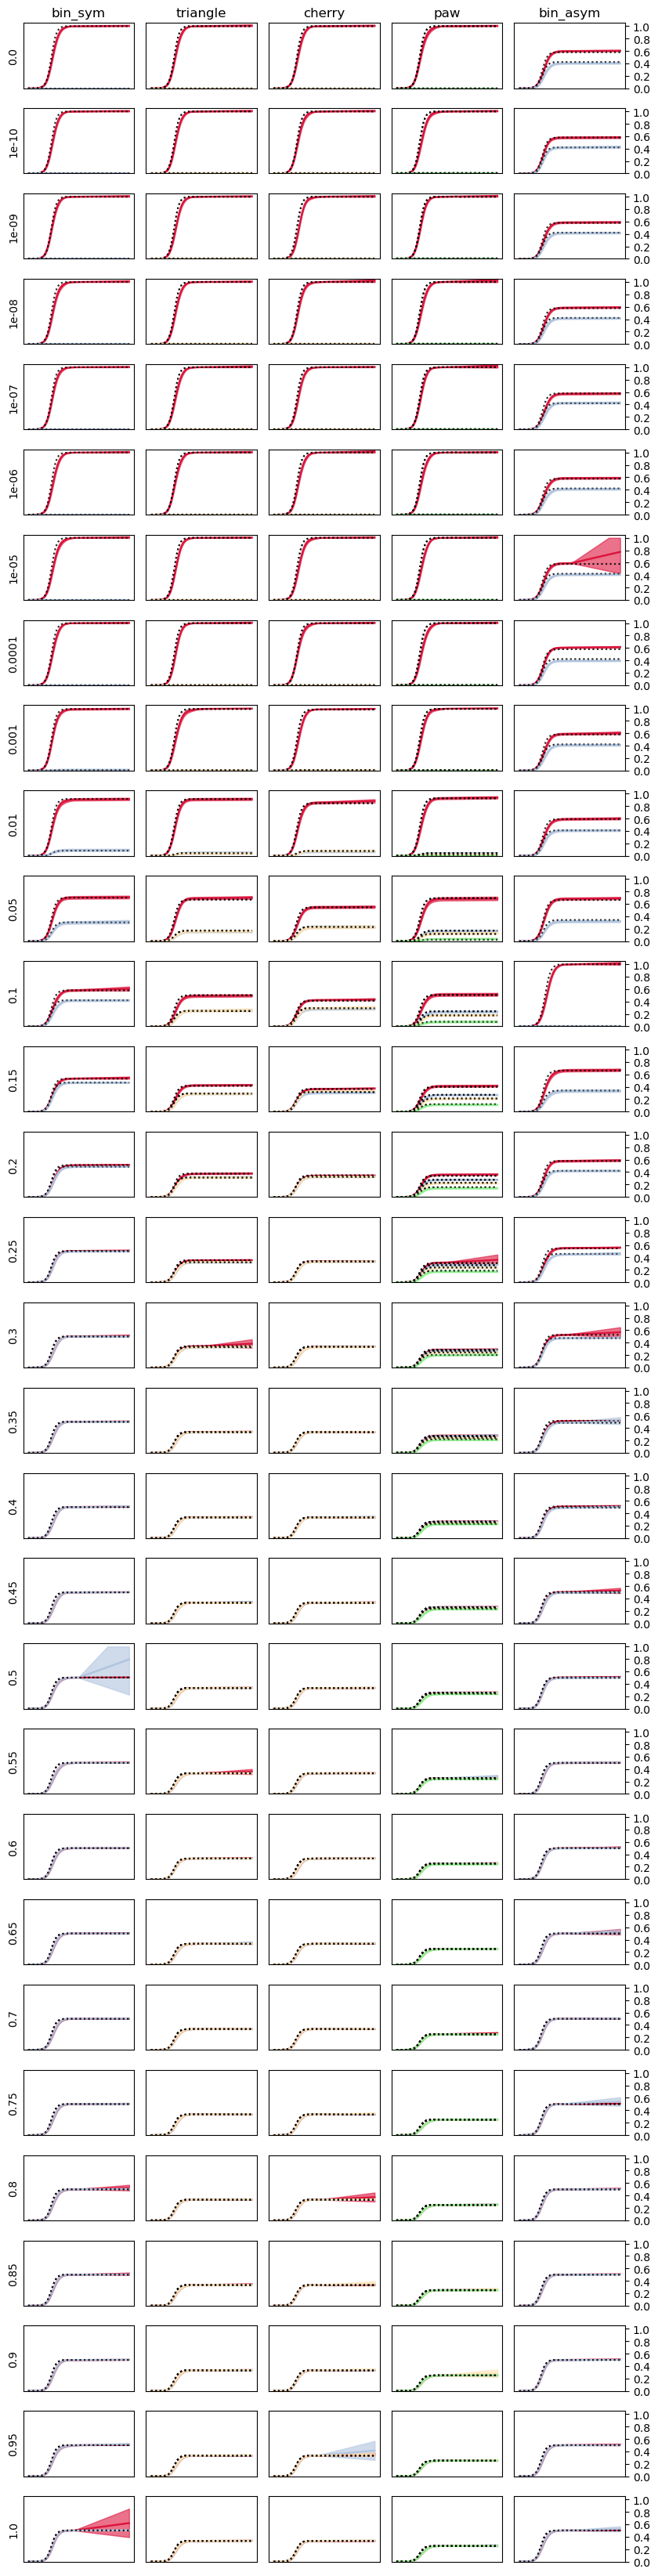

In [12]:
#num_errors = 2
#num_channels = 2

mean_gillespie_results = {
    
    'bin_sym': {err: [] for err in all_errors},
    'triangle': {err: [] for err in all_errors},
    'cherry': {err: [] for err in all_errors},
    'paw': {err: [] for err in all_errors},
    'bin_asym': {err: [] for err in all_errors}
    
}

mean_field_results = {
    
    'bin_sym': {err: [] for err in all_errors},
    'triangle': {err: [] for err in all_errors},
    'cherry': {err: [] for err in all_errors},
    'paw': {err: [] for err in all_errors},
    'bin_asym': {err: [] for err in all_errors}
    
}


fig, axs = plt.subplots(num_errors, num_channels, figsize=(8.5,33))

channel_idx = 0
for name,channel_dict in channel_mapping.items():
    
    error_idx = 0
    for err, channel in channel_dict.items():
        
        alphabet_size = channel.shape[0]
        
        # Initial state always set to 1 observer encoding message 0
        initial_state = np.array([1] + [0]*(alphabet_size-1)) 
    
        # Noisy Gillespie Algorithm
        runs = list()
        for _ in tqdm(range(num_runs)):
            
            sim = NoisyGillespie(N=N, initial_state=initial_state, beta=beta, k=k, 
                                channel=channel)
            test_sim = sim.simulate(max_time=T, density=True)
            runs.append((test_sim[0], test_sim[1]))
                                     
        # Interpolating Gillespie Means
        common_time = np.linspace(0, T, T+1)
        interpolated_values = []
        
        for run_t, run_y in runs:
            interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
            interpolated_values.append(interp_func(common_time))
        
        interp_sim_arr = np.array(interpolated_values)
        
        sim_means = np.mean(interp_sim_arr, axis=0)

        sim_se = np.std(interp_sim_arr, axis=0) / np.sqrt(num_runs)
        conf_int = 1.96 * sim_se

        sim_lower = sim_means - conf_int
        sim_higher = sim_means + conf_int

        sim_lower = np.clip(sim_lower, 0, 1)
        sim_higher = np.clip(sim_higher, 0, 1)
        
        # Mean-Field
        mean_field = ODE(beta=beta, k=k, channel=channel, T=T,t_eval=common_time)
        analytic_curve = mean_field(initial_state=initial_state/N)


        for dim in range(sim_means.shape[1]):
            axs[error_idx, channel_idx].plot(common_time, sim_means[:, dim], color=colors[dim])
            axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_lower[:, dim], 
                                                     alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_higher[:, dim], 
                                                     alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].plot(analytic_curve.t, analytic_curve.y.T, linestyle='dotted', alpha=0.6, 
                                            color='black', markersize=4)
            
        mean_gillespie_results[name][err].append((common_time, sim_means, sim_lower, sim_higher))
        mean_field_results[name][err].append((analytic_curve.t, analytic_curve.y.T))
            
        axs[error_idx, channel_idx].set_ylim(0, 1.05)
        

        if error_idx==0:
            axs[error_idx, channel_idx].set_title(name)

        if channel_idx==0:
            axs[error_idx, channel_idx].set_ylabel(f"{float(err):.3}")   

        if channel_idx==num_channels-1:
            axs[error_idx, channel_idx].yaxis.tick_right()
            axs[error_idx, channel_idx].yaxis.set_label_position("right")
            axs[error_idx, channel_idx].set_yticks(np.linspace(0,1,6))
        else:
            axs[error_idx, channel_idx].set_yticks([])

        axs[error_idx, channel_idx].set_xticks([]) 
            
        
        # Only show axes until the end of the average simulation
            
        error_idx += 1

    channel_idx += 1
    
    
plt.tight_layout()
plt.show()

#fig.savefig('/home/sagar/modeling-info-spread/reports/figures/full_continuous_phi_plots_2.pdf')

In [13]:
with open('/data_users1/sagar/modeling-info-spread/pickles/all_channels_monte_carlo.pkl', 'wb') as f_mc:
    pickle.dump(mean_gillespie_results, f_mc)

In [14]:
with open('/data_users1/sagar/modeling-info-spread/pickles/all_channels_mean_field', 'wb') as f_mf:
    pickle.dump(mean_field_results, f_mf)

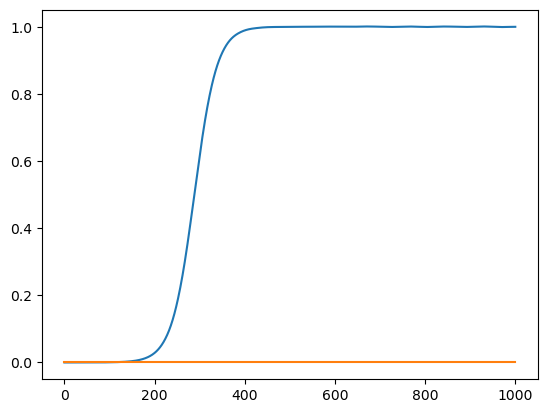

In [863]:
mean_field_test = ODE(beta=beta, k=k, channel=bin_asym_channel(0.1, (0.1 - 0.1) % 1), T=T,t_eval=np.linspace(0,1000,21))
analytic_curve_test = mean_field(initial_state=np.array([1,0])/N)
plt.plot(analytic_curve_test.t, analytic_curve_test.y.T)

In [15]:
fig.savefig('/home/sagar/modeling-info-spread/reports/figures/full_continuous_phi_plots_3.pdf')

In [ ]:
os.listdir('/data_users1/sagar/modeling-info-spread')

In [16]:
abridged_errors = all_errors[(all_errors < 0.3) & (all_errors > 1e-3)]

In [17]:
abridged_errors

array([0.01, 0.05, 0.1 , 0.15, 0.2 , 0.25])

In [18]:
abridged_errors.size

6

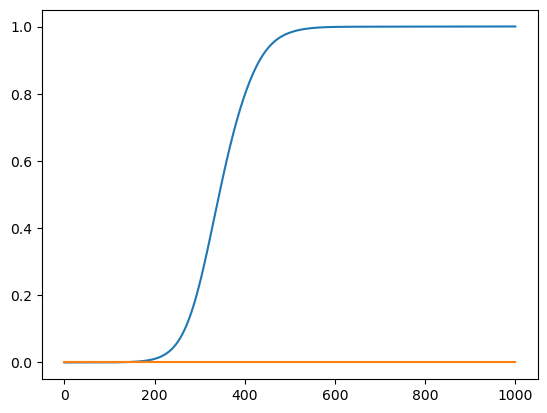

In [884]:
plt.plot(mean_gillespie_asym[0.1][0][0], mean_gillespie_asym[0.1][0][1])

In [883]:
mean_gillespie_asym[0.1][0]

(array([   0.,    1.,    2., ...,  998.,  999., 1000.]),
 array([[1.00000000e-05, 0.00000000e+00],
        [1.14655987e-05, 0.00000000e+00],
        [1.25558867e-05, 0.00000000e+00],
        ...,
        [1.00058319e+00, 0.00000000e+00],
        [1.00058492e+00, 0.00000000e+00],
        [1.00058665e+00, 0.00000000e+00]]),
 array([[1.00000000e-05, 0.00000000e+00],
        [1.10064207e-05, 0.00000000e+00],
        [1.18625460e-05, 0.00000000e+00],
        ...,
        [1.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 0.00000000e+00]]),
 array([[1.00000000e-05, 0.00000000e+00],
        [1.19247766e-05, 0.00000000e+00],
        [1.32492274e-05, 0.00000000e+00],
        ...,
        [1.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 0.00000000e+00]]))

In [20]:
with open('/data_users1/sagar/modeling-info-spread/pickles/all_channels_monte_carlo.pkl', 'rb') as f_mc:
    mean_gillespie_results = pickle.load(f_mc)

In [21]:
with open('/data_users1/sagar/modeling-info-spread/pickles/all_channels_mean_field', 'rb') as f_mf:
    mean_field_results = pickle.load(f_mf)

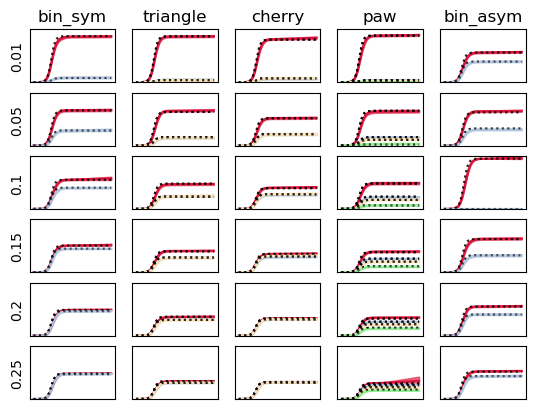

In [24]:
fig, axs = plt.subplots(abridged_errors.size, len(mean_gillespie_results.keys()))

channel_idx = 0
for name, sim_dict in mean_gillespie_results.items():
    
    analytical_dict = mean_field_results.get(name)
    
    error_idx = 0
    for err in abridged_errors:
        
        common_time, sim_means, sim_lower, sim_higher = sim_dict.get(err)[0]
        analytic_time, analytic_curve = analytical_dict.get(err)[0]
        
        for dim in range(sim_means.shape[1]):
            axs[error_idx, channel_idx].plot(common_time, sim_means[:, dim], color=colors[dim])
            axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_lower[:, dim], 
                                                     alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_higher[:, dim], 
                                                     alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].plot(analytic_time, analytic_curve, linestyle='dotted', alpha=0.6, 
                                            color='black', markersize=4)
            
        axs[error_idx, channel_idx].set_ylim(0, 1.05)
        

        if error_idx==0:
            axs[error_idx, channel_idx].set_title(name)

        if channel_idx==0:
            axs[error_idx, channel_idx].set_ylabel(f"{float(err):.3}")   

        if channel_idx==num_channels-1:
            #axs[error_idx, channel_idx].yaxis.tick_right()
            #axs[error_idx, channel_idx].yaxis.set_label_position("right")
            #axs[error_idx, channel_idx].set_yticks(np.linspace(0,1,3))
            axs[error_idx, channel_idx].set_yticks([])
        else:
            axs[error_idx, channel_idx].set_yticks([])

        axs[error_idx, channel_idx].set_xticks([]) 
        
        error_idx += 1
        
    channel_idx += 1
    
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/abridged_continuous_phi_plots_2.pdf')

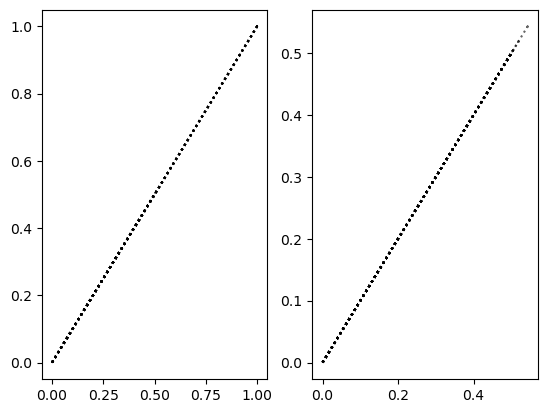

In [144]:
fig, axs = plt.subplots(1, 2)

channel_idx = 0
for name in ['bin_sym', 'bin_asym']:
    
    sim_dict = mean_gillespie_results.get(name)
    
    analytical_dict = mean_field_results.get(name)
    
    for err in all_errors:
        
        common_time, sim_means, sim_lower, sim_higher = sim_dict.get(err)[0]
        analytic_time, analytic_curve = analytical_dict.get(err)[0]
        
        #axs[channel_idx].plot(sim_means[:, 0], sim_means[:, 1], color=colors[dim])
        #axs[channel_idx].fill_between(common_time, sim_means[:, dim], sim_lower[:, dim], 
                                                     #alpha=0.6, color=colors[dim])
        #axs[channel_idx].fill_between(common_time, sim_means[:, dim], sim_higher[:, dim], 
                                                     #alpha=0.6, color=colors[dim])
        axs[channel_idx].plot([y[0] for y in analytic_curve], [y[0] for y in analytic_curve], linestyle='dotted', alpha=0.6, 
                                            color='black', markersize=4)
        
    channel_idx += 1
        
    """     
    axs[error_idx, channel_idx].set_ylim(0, 1.05)


    if error_idx==0:
        axs[error_idx, channel_idx].set_title(name)

    if channel_idx==0:
        axs[error_idx, channel_idx].set_ylabel(f"{float(err):.3}")   

    if channel_idx==num_channels-1:
        axs[error_idx, channel_idx].yaxis.tick_right()
        axs[error_idx, channel_idx].yaxis.set_label_position("right")
        axs[error_idx, channel_idx].set_yticks(np.linspace(0,1,6))
    else:
        axs[error_idx, channel_idx].set_yticks([])

    axs[error_idx, channel_idx].set_xticks([]) 
    """

In [145]:
bin_sym_mf = mean_field_results.get('bin_sym')

In [150]:
bin_sym_test = bin_sym_mf.get(0.01)[0][1]

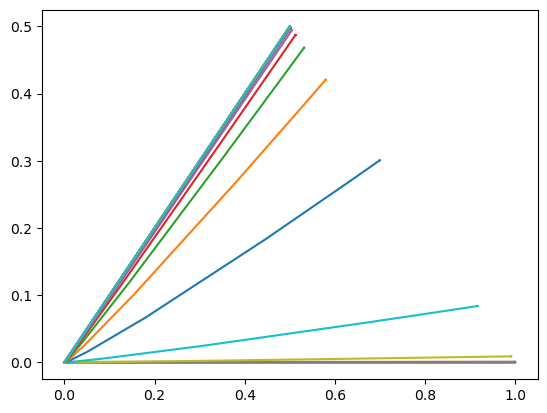

In [152]:
for err in all_errors:
    bin_sym_test = bin_sym_mf.get(err)[0][1]
    plt.plot(bin_sym_test[:, 0], bin_sym_test[:, 1])

In [297]:
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

colormap = plt.cm.plasma # set colormap

for n,name in enumerate(['bin_sym', 'bin_asym_var', 'bin_asym_fixed']):
    
    mf = mean_field_results.get(name)
    #gillespie = mean_gillespie_results.get(name)
    
    for e in range(100):
        
        err = e/100
        
        if name == 'bin_sym':
            channel = single_flip_channel(1, err)
        elif name == 'bin_asym_var':
            channel = bin_asym_channel(0.3, (0.3 - err) % 1)
        elif name == 'bin_asym_fixed':
            channel = bin_asym_channel(err, (err - 0.3 )% 1)
        else: 
            raise ValueError
            
        
            
        initial_state = np.array([1,0])
        
        # Mean Field    
        mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
        analytic_curve = mean_field(initial_state=initial_state/N)
        

        inst = analytic_curve.y.T
        axs[n].plot(inst[:, 0], inst[:, 1], linestyle='dotted', color='k')
        
        # Simulation
        runs = list()
        for _ in tqdm(range(100)):
            
            sim = NoisyGillespie(N=N, initial_state=initial_state, beta=beta, k=k, 
                                channel=channel)
            test_sim = sim.simulate(max_time=T, density=True)
            runs.append((test_sim[0], test_sim[1]))
                                     
        # Interpolating Gillespie Means
        common_time = np.linspace(0, T, T+1)
        interpolated_values = []
        
        for run_t, run_y in runs:
            interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
            interpolated_values.append(interp_func(common_time))
        
        interp_sim_arr = np.array(interpolated_values)
        
        sim_means = np.mean(interp_sim_arr, axis=0)
        
        axs[n].plot(sim_means[:, 0], sim_means[:, 1], color=colormap(err), alpha=0.8)
        
        # Surface
        axs[n].plot([x for x in np.linspace(0, 1, 100)], [1 - x for x in np.linspace(0,1,100)], 'k')
        
        if n > 0:
            axs[n].set_yticks([])
        
    axs[n].set_ylim(0,1)
    axs[n].set_xlim(0,1)

    
# setup the colorbar
normalize = mcolors.Normalize(vmin=0, vmax=1)
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array([i/100 for i in range(100)])
plt.colorbar(scalarmappaple, ax=axs, label=r'$\epsilon$')

#fig.savefig('/home/sagar/modeling-info-spread/reports/figures/continuous_phase_space_1d.pdf')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



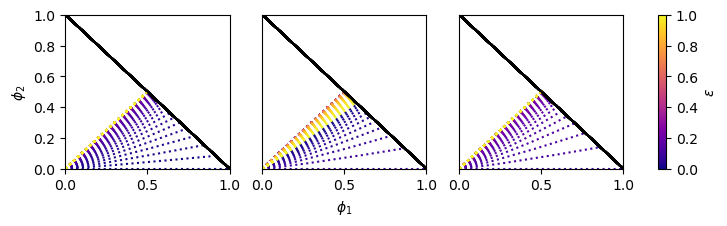

In [506]:
# Change 0.3 to 0.1 in the binary asymmetric

fig, axs = plt.subplots(1, 3, figsize=(9, 2))

colormap = plt.cm.plasma # set colormap

for n,name in enumerate(['bin_sym', 'bin_asym_var', 'bin_asym_fixed']):
    
    mf = mean_field_results.get(name)
    
    for e in range(100):
        
        err = e/100
        
        if name == 'bin_sym':
            channel = single_flip_channel(1, err)
        elif name == 'bin_asym_var':
            channel = bin_asym_channel(0.1, (0.1 - err) % 1)
        elif name == 'bin_asym_fixed':
            channel = bin_asym_channel(err, (err - 0.1 )% 1)
        else: 
            raise ValueError
            
            
        initial_state = np.array([1,0])
        
        # Mean Field    
        mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
        analytic_curve = mean_field(initial_state=initial_state/N)
        

        inst = analytic_curve.y.T
        axs[n].plot(inst[:, 0], inst[:, 1], linestyle='dotted', color=colormap(e/100))
        
        # Surface
        axs[n].plot([x for x in np.linspace(0, 1, 100)], [1 - x for x in np.linspace(0,1,100)], 'k')
        
        if n > 0:
            axs[n].set_yticks([])
        
    axs[n].set_ylim(0,1)
    axs[n].set_xlim(0,1)
    
    if n == 0: 
        axs[n].set_ylabel(r'$\phi_2$')
        
    if n == 1:
        axs[n].set_xlabel(r'$\phi_1$')

    
# setup the colorbar
normalize = mcolors.Normalize(vmin=0, vmax=1)
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array([i/100 for i in range(100)])
plt.colorbar(scalarmappaple, ax=axs, label=r'$\epsilon$')

#fig.savefig('/home/sagar/modeling-info-spread/reports/figures/continuous_phase_space_analytical_only_1d.pdf')

In [217]:
bin_asym_channel(0.3, (0.3 - 0.8) % 1)

array([[0.7, 0.3],
       [0.5, 0.5]])

In [219]:
from matplotlib import tri

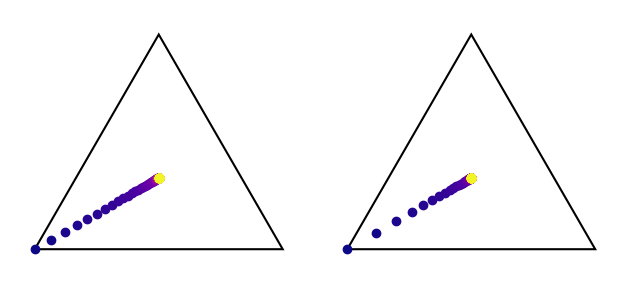

In [377]:
def cartesian_to_barycentric(point):
    
    """
    Convert a 3D point that sums to 1 into 2D Cartesian coordinates on a given triangle.
    
    Parameters:
    point (list or np.array): A 3D point (x, y, z) where x + y + z = 1
    
    Returns:
    np.array: 2D Cartesian coordinates (X, Y)
    """
    #if not np.isclose(sum(point), 1):
    #    raise ValueError("The sum of the point coordinates must be 1.")
    
    # Triangle vertices
    A = np.array([0, 0])
    B = np.array([1, 0])
    C = np.array([0.5, np.sqrt(3) / 2])
    
    # Barycentric coordinates are the same as the 3D point coordinates
    u, v, w = point
    
    # Cartesian coordinates
    P = u * A + v * B + w * C
    
    return P

fig, axs = plt.subplots(1, 2)

vertices = np.array([
    [0, 0],
    [1, 0],
    [0.5, np.sqrt(3)/2]
])
    
colormap = plt.cm.plasma

triangle = plt.Polygon(vertices, edgecolor='k', fill=None, linewidth=1.5)

### First Three-Message Channel
axs[0].add_patch(triangle)

points_3d = []
for e in range(100):
    
    err = e/100
    
    channel = simplex_channel(3, err)
    
    initial_state = np.array([1, 0, 0])
    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve = mean_field(initial_state=initial_state/N)
    points_3d.append(analytic_curve.y.T[-1])

points_3d = np.array(points_3d)

# Convert to barycentric coordinates
#points_barycentric = cartesian_to_barycentric(points_3d)

for n, point in enumerate(points_3d):
    bary_point = cartesian_to_barycentric(point)
    axs[0].scatter(bary_point[0], bary_point[1], color=colormap(n/100))
    
#Label the vertices
#labels = [r'$\phi_1$', r'$\phi_2$', r'$\phi_3$']
#offset = [(-20, 0), (20, 0), (0, 20) ]
#for i, txt_off in enumerate(zip(labels, offset)):
#    txt = txt_off[0]
#    off = txt_off[1]
#    axs[0].annotate(txt, (vertices[i, 0], vertices[i, 1]), fontsize=15, ha='center',
#               xytext=off, textcoords='offset pixels')

# Set aspect of the plot to be equal
axs[0].set_aspect('equal')

# Set limits and remove ticks
axs[0].set_xlim(-0.1, 1.1)
axs[0].set_ylim(-0.1, np.sqrt(3)/2 + 0.1)
axs[0].set_xticks([])
axs[0].set_yticks([])

for spine in axs[0].spines.values():
    spine.set_visible(False)
    
    
## Second Three-Message Channel
triangle_1 = plt.Polygon(vertices, edgecolor='k', fill=None, linewidth=1.5)
axs[1].add_patch(triangle_1)

points_3d_1 = []
for e in range(100):
    
    err = e/100
    
    channel = star_channel(3, err)
    
    initial_state = np.array([1, 0, 0])
    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve = mean_field(initial_state=initial_state/N)
    points_3d_1.append(analytic_curve.y.T[-1])

points_3d_1 = np.array(points_3d_1)

# Convert to barycentric coordinates
#points_barycentric = cartesian_to_barycentric(points_3d)

for n, point in enumerate(points_3d_1):
    bary_point = cartesian_to_barycentric(point)
    axs[1].scatter(bary_point[0], bary_point[1], color=colormap(n/100))
    
#Label the vertices
#labels = [r'$\phi_1$', r'$\phi_2$', r'$\phi_3$']
#offset = [(-20, 0), (20, 0), (0, 20) ]
#for i, txt_off in enumerate(zip(labels, offset)):
#    txt = txt_off[0]
#    off = txt_off[1]
#    axs[1].annotate(txt, (vertices[i, 0], vertices[i, 1]), fontsize=15, ha='center',
#               xytext=off, textcoords='offset pixels')

# Set aspect of the plot to be equal
axs[1].set_aspect('equal')

# Set limits and remove ticks
axs[1].set_xlim(-0.1, 1.1)
axs[1].set_ylim(-0.1, np.sqrt(3)/2 + 0.1)
axs[1].set_xticks([])
axs[1].set_yticks([])

for spine in axs[1].spines.values():
    spine.set_visible(False)
    
    
    
plt.tight_layout()

fig.savefig('/home/sagar/modeling-info-spread/reports/figures/continuous_phase_space_analytical_only_2d.pdf')

plt.show()




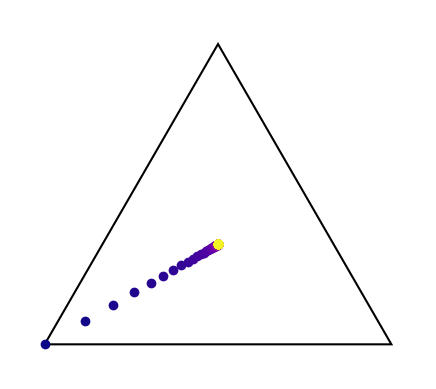

In [282]:
fig, ax = plt.subplots()

vertices = np.array([
    [0, 0],
    [1, 0],
    [0.5, np.sqrt(3)/2]
])
    
colormap = plt.cm.plasma

triangle = plt.Polygon(vertices, edgecolor='k', fill=None, linewidth=1.5)
ax.add_patch(triangle)

points_3d = []
for e in range(100):
    
    err = e/100
    
    channel = star_channel(3, err)
    
    initial_state = np.array([1, 0, 0])
    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve = mean_field(initial_state=initial_state/N)
    points_3d.append(analytic_curve.y.T[-1])

points_3d = np.array(points_3d)

# Convert to barycentric coordinates
#points_barycentric = cartesian_to_barycentric(points_3d)

for n, point in enumerate(points_3d):
    bary_point = cartesian_to_barycentric(point)
    ax.scatter(bary_point[0], bary_point[1], color=colormap(n/100))
    
#Label the vertices
labels = [r'$\phi_1$', r'$\phi_2$', r'$\phi_3$']
offset = [(-20, 0), (20, 0), (0, 20) ]
for i, txt_off in enumerate(zip(labels, offset)):
    txt = txt_off[0]
    off = txt_off[1]
    ax.annotate(txt, (vertices[i, 0], vertices[i, 1]), fontsize=15, ha='center',
               xytext=off, textcoords='offset pixels')

# Set aspect of the plot to be equal
ax.set_aspect('equal')

# Set limits and remove ticks
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, np.sqrt(3)/2 + 0.1)
ax.set_xticks([])
ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_visible(False)
    
    

plt.show()

In [287]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

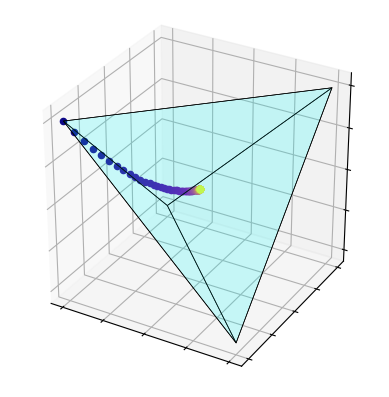

In [375]:
def cartesian_to_barycentric_4d(point, vertices):
    a, b, c, d = point
    return a * vertices[0] + b * vertices[1] + c * vertices[2] + d * vertices[3]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

vertices = np.array([
    [-1, -1, 1],
    [-1, 1, -1],
    [1, -1, -1],
    [1, 1, 1]
])

#vertices = np.array([
#    [-1, -1, -1],
#    [1, -1, -1],
#    [np.sqrt(3)/2, 1, -1],
#    [np.sqrt(3)/2, np.sqrt(3)/2, 1]
#])
    
points_4d = []
for e in range(100):
    
    err = e/100
    
    channel = paw_channel(err)
    
    initial_state = np.array([1, 0, 0, 0])
    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve = mean_field(initial_state=initial_state/N)
    points_4d.append(analytic_curve.y.T[-1])

for n, point in enumerate(points_4d):
    bary_point = barycentric_to_cartesian_4d(point, vertices)
    ax.scatter(bary_point[0], bary_point[1], bary_point[2], color=colormap(n/100))
    
    
faces = [[vertices[j] for j in [0, 1, 2]],
         [vertices[j] for j in [0, 1, 3]],
         [vertices[j] for j in [0, 2, 3]],
         [vertices[j] for j in [1, 2, 3]]] 

#Label the vertices
#labels = [r'$\phi_1$', r'$\phi_2$', r'$\phi_3$', r'$\phi_4$']
#offset = [(-20, 0), (20, 0), (0, 20), (0, -20)]
#for i, txt_off in enumerate(zip(labels, offset)):
#    txt = txt_off[0]
#    off = txt_off[1]
#    ax.annotate(txt, (vertices[i, 0], vertices[i, 1]), fontsize=15, ha='center',
#               xytext=off, textcoords='offset pixels')
#
ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=0.5, edgecolors='k',
                                     alpha=0.1))

ax.set_box_aspect([1, 1, 1])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_zlim([-1.1, 1.1])

fig.savefig('/home/sagar/modeling-info-spread/reports/figures/continuous_phase_space_analytical_only_3dd.pdf')

## Poincare Map

In [369]:
channel = single_flip_channel(1, 0.1)
initial_state = np.array([1,0])
mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
analytic_curve = mean_field(initial_state=initial_state/N)

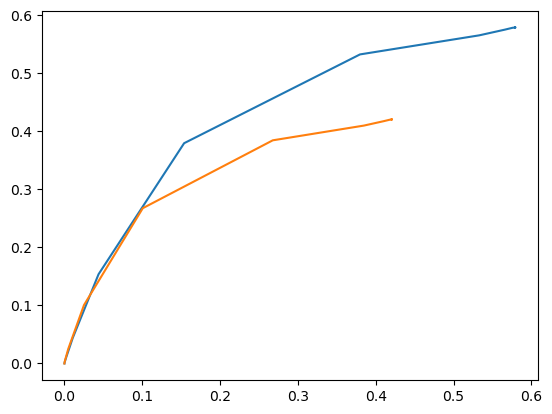

In [371]:
num_pts = analytic_curve.y[0].shape[0]
plt.plot([analytic_curve.y[0][t] for t in range(num_pts-1)], [analytic_curve.y[0][t] for t in range(1,num_pts)])
plt.plot([analytic_curve.y[1][t] for t in range(num_pts-1)], [analytic_curve.y[1][t] for t in range(1,num_pts)])

In [365]:
T

1000

# Conditional Entropy

In [10]:
def shannon_entropy(p: np.ndarray):
    
    """
    Calculate Shannon Entropy 
    
    :param p: 1D np array 
    """
    
    p = p / np.sum(p, axis=1, keepdims=True)
    
    p = p + 1e-7 # ensuring no nans
    
    
    return -1 * np.sum(p * np.log2(p), axis=1)

In [ ]:
fig, axs = plt.subplots(abridged_errors.size, len(mean_gillespie_results.keys()))

channel_idx = 0
for name, sim_dict in mean_gillespie_results.items():
    
    analytical_dict = mean_field_results.get(name)
    
    error_idx = 0
    for err in abridged_errors:
        
        common_time, sim_means, sim_lower, sim_higher = sim_dict.get(err)[0]
        analytic_time, analytic_curve = analytical_dict.get(err)[0]
        
        sim_h = 
        
        for dim in range(sim_means.shape[1]):
            axs[error_idx, channel_idx].plot(common_time, sim_means[:, dim], color=colors[dim])
            #axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_lower[:, dim], 
                                                     #alpha=0.6, color=colors[dim])
            #axs[error_idx, channel_idx].fill_between(common_time, sim_means[:, dim], sim_higher[:, dim], 
                                                     #alpha=0.6, color=colors[dim])
            axs[error_idx, channel_idx].plot(analytic_time, analytic_curve, linestyle='dotted', alpha=0.6, 
                                            color='black', markersize=4)
            
        axs[error_idx, channel_idx].set_ylim(0, 1.05)
        

        if error_idx==0:
            axs[error_idx, channel_idx].set_title(name)

        if channel_idx==0:
            axs[error_idx, channel_idx].set_ylabel(f"{float(err):.3}")   

        if channel_idx==num_channels-1:
            axs[error_idx, channel_idx].yaxis.tick_right()
            axs[error_idx, channel_idx].yaxis.set_label_position("right")
            axs[error_idx, channel_idx].set_yticks(np.linspace(0,1,6))
        else:
            axs[error_idx, channel_idx].set_yticks([])

        axs[error_idx, channel_idx].set_xticks([]) 
        
        error_idx += 1
        
    channel_idx += 1

In [443]:
shannon_entropy(mean_field_results.get('bin_sym').get(0.1)[0][1])

array([0.00133228, 0.00134956, 0.00153146, 0.00519923, 0.0283739 ,
       0.10798344, 0.33156615, 0.74888302, 1.03944018, 1.01415033,
       0.99233568, 0.9848407 , 0.98232315, 0.98186976, 0.98183405,
       0.9820349 , 0.98197104, 0.98192166, 0.98201761, 0.98202486,
       0.98183288])

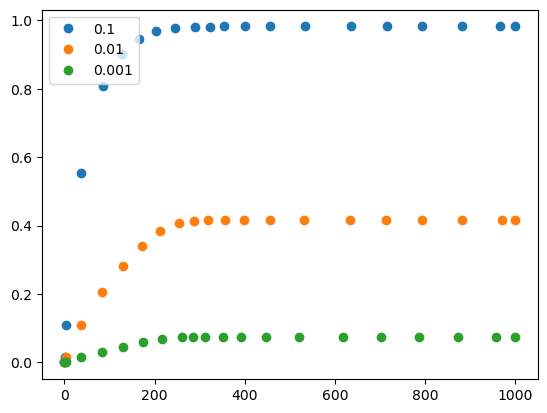

In [477]:
plt.plot(mean_field_results.get('bin_sym').get(0.1)[0][0], 
         shannon_entropy(mean_field_results.get('bin_sym').get(0.1)[0][1]), 'o',
        label='0.1')


plt.plot(mean_field_results.get('bin_sym').get(0.01)[0][0], 
         shannon_entropy(mean_field_results.get('bin_sym').get(0.01)[0][1]), 'o',
        label='0.01')


plt.plot(mean_field_results.get('bin_sym').get(0.001)[0][0], 
         shannon_entropy(mean_field_results.get('bin_sym').get(0.001)[0][1]), 'o',
        label='0.001')

plt.legend()

In [448]:
mean_gillespie_results.get('bin_sym').get(0.1)[0]

(array([   0.,    1.,    2., ...,  998.,  999., 1000.]),
 array([[1.00000000e-04, 0.00000000e+00],
        [1.13854052e-04, 2.67647718e-06],
        [1.21748575e-04, 4.27836734e-06],
        ...,
        [5.86882772e-01, 4.27027978e-01],
        [5.86897072e-01, 4.27040453e-01],
        [5.86911372e-01, 4.27052927e-01]]),
 array([[1.00000000e-04, 0.00000000e+00],
        [1.08221611e-04, 2.87638514e-07],
        [1.15208491e-04, 9.48467645e-07],
        ...,
        [5.70908501e-01, 4.11522445e-01],
        [5.70917815e-01, 4.11529372e-01],
        [5.70927124e-01, 4.11536289e-01]]),
 array([[1.00000000e-04, 0.00000000e+00],
        [1.19486492e-04, 5.06531584e-06],
        [1.28288660e-04, 7.60826703e-06],
        ...,
        [6.02857043e-01, 4.42533510e-01],
        [6.02876329e-01, 4.42551533e-01],
        [6.02895620e-01, 4.42569565e-01]]))

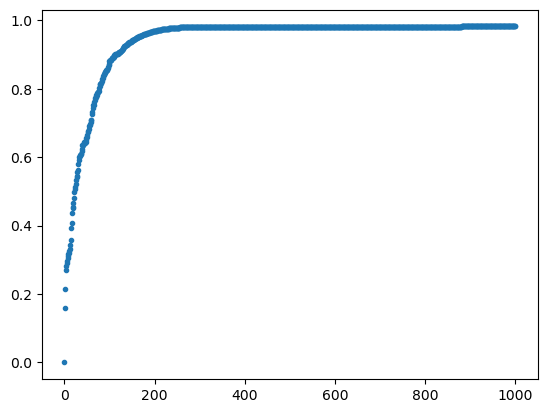

In [471]:
plt.plot(mean_gillespie_results.get('bin_sym').get(0.1)[0][0], shannon_entropy(mean_gillespie_results.get('bin_sym').get(0.1)[0][1]), '.')
#plt.plot(mean_gillespie_results.get('bin_sym').get(0.1)[0][0], shannon_entropy(mean_gillespie_results.get('bin_sym').get(0.1)[0][2]), '-')
#plt.plot(mean_gillespie_results.get('bin_sym').get(0.1)[0][0], shannon_entropy(mean_gillespie_results.get('bin_sym').get(0.1)[0][3]), '-')


#plt.fill_between(mean_gillespie_results.get('bin_sym').get(0.1)[0][0], shannon_entropy(mean_gillespie_results.get('bin_sym').get(0.1)[0][2]), shannon_entropy(mean_gillespie_results.get('bin_sym').get(0.1)[0][3]))

In [461]:
mean_gillespie_results.get('bin_sym').get(0.1)[0][1]

array([0.32895587, 0.23230586])

## 

## Entropy Increase by Error

In [ ]:
## ADD SIMULATIONS TO THIS

# Save as 0.1 asym

#fig, axs = plt.subplots(2, 3, figsize=(9, 4))
num_runs = 100
resolution = 100

final_dists = []

colormap = plt.cm.plasma # set colormap

#for n,name in tqdm(enumerate(['bin_sym', 'bin_asym_var', 'bin_asym_fixed', 
#                        'triangle', 'cherry', 'paw'])):
    
for n,name in tqdm(enumerate(['bin_sym', 'bin_asym_var','triangle', 'cherry', 'paw'])):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    #mf = mean_field_results.get(name)
    final_dist = []
    
    cond_sim_means = []
    
    for e in range(resolution):
        
        err = e/resolution
        
        if name == 'bin_sym':
            channel = single_flip_channel(1, err)
        elif name == 'bin_asym_var':
            channel = bin_asym_channel(0.1, (0.1 - err) % 1)
        elif name == 'bin_asym_fixed':
            channel = bin_asym_channel(err, (err - 0.1)% 1)
        elif name == 'triangle': 
            channel = simplex_channel(3, err)
        elif name == 'cherry': 
            channel = star_channel(3, err)
        elif name == 'paw': 
            channel = paw_channel(err)
        else: 
            raise ValueError
            
            
        initial_state = np.array([1] + [0]*(channel.shape[0]-1))
        
        cond_ent_runs = []
        # Noisy Gillespie Algorithm
        runs_x1 = list()
        for _ in tqdm(range(num_runs)):

            sim_x1 = NoisyGillespie(N=N, initial_state=initial_state, beta=beta, k=k, 
                                channel=channel)
            test_sim = sim_x1.simulate(max_time=T, density=True)
            runs_x1.append(test_sim[1][-1])

        se = np.std(shannon_entropy(np.array(runs_x1))) / np.sqrt(num_runs)
        conf_int = 1.96 * MI_se

        sim_means = np.mean(shannon_entropy(np.array(runs_x1)))
        cond_sim_means.append((sim_means, conf_int))
        
        # Mean Field    
        mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
        analytic_curve = mean_field(initial_state=initial_state/N)
        

        inst = analytic_curve.y.T
        
        final_dist.append(inst[-1, :])
        
    ax.set_yscale('linear')    
    ax.plot([e/resolution for e in range(resolution)], shannon_entropy(np.array(final_dist)), 
                        '+', color='darkorange')
    ax.errorbar(x=[e/resolution for e in range(resolution)], y=[tup[0] for tup in cond_sim_means], 
                 yerr=[tup[1] for tup in cond_sim_means], marker='.', linestyle='none', 
                 color='indigo', ecolor='darkviolet')
    fig.savefig(f'/home/sagar/modeling-info-spread/reports/figures/conditional_entropy_{name}-lin.pdf')
    
    ax.set_yscale('log')
    ax.plot([e/resolution for e in range(resolution)], shannon_entropy(np.array(final_dist)), 
                        '+', color='darkorange')
    ax.errorbar(x=[e/resolution for e in range(resolution)], y=[tup[0] for tup in cond_sim_means], 
                 yerr=[tup[1] for tup in cond_sim_means], marker='.', linestyle='none', 
                 color='indigo', ecolor='darkviolet')
    fig.savefig(f'/home/sagar/modeling-info-spread/reports/figures/conditional_entropy_{name}-log.pdf')

        
    #axs[n // 3, n % 3].plot([e/1000 for e in range(1000)], shannon_entropy(np.array(final_dist)), 
    #                        '.', color='purple', markersize=0.7)
    #axs[n // 3, n % 3].axhline(np.log2(initial_state.shape), 0, 1, linestyle='dashed', color='k', linewidth=0.8)
    #
    #if n // 3 == 0:
    #    axs[n // 3, n % 3].set_xticks([])
    #
    #final_dists.append(final_dist)
    #    
        
    
#fig.savefig('/home/sagar/modeling-info-spread/reports/figures/temporary_H_by_eps.pdf')

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Mutual Information

In [4]:
def mutual_info(M, X):
    # Ensure the inputs are normalized
    assert np.isclose(np.sum(X), 1.0), "X should be normalized"
    assert np.all(np.isclose(np.sum(M, axis=1), 1.0)), "Rows of M should sum to 1"

    num_x = M.shape[0]
    num_y = M.shape[1]

    # Calculate p(y)
    p_y = np.dot(X, M)

    # Calculate p(x, y)
    p_xy = np.zeros((num_x, num_y))
    for x in range(num_x):
        for y in range(num_y):
            p_xy[x, y] = X[x] * M[x, y]

    def log_term(x, y):
        if p_xy[x, y] > 0 and p_y[y] > 0:  # Ensure we don't divide by zero or take log of zero
            log_value = np.log2(p_xy[x, y] / (X[x] * p_y[y]))
            return log_value
        return 0

    I = np.sum([p_xy[x, y] * log_term(x, y) for x in range(num_x) for y in range(num_y)])
    
    return I

# Example usage:
M = np.array([[0.28, 0.72], [0.72, 0.28]])
X = np.array([0.5, 0.5])
result = mutual_info(M, X)
print("Mutual Information:", result)

Mutual Information: 0.14454918943986927


In [ ]:
# mutual info requires E to be a channel... So do we keep Q fixed as bin sym and vary E?

In [539]:
#fig, axs = plt.subplots(1, len(mean_gillespie_results.keys()))

resolution = 20

X = np.array([0.5, 0.5]) # Hard-Code uniform input distribution

channel_idx = 0
for name, channel_dict in channel_mapping.items():
    
    channel = channel_dict.get(0.01) # Hard-Coding distortion likelihood of 0.01 so perfect encoding is good
    
    MI_phi = []
    MI_enc = []
    
    for dim in range(channel.shape[0]):
        
        X = np.array([1/channel.shape[0]]*channel.shape[0])
        
        # Creating all N-tuples of initial coords --- THIS DOESN'T WORK
        
        # Need to create BSC and vary the distortion from 0 to 0.5 to sweep through the possible values
        # Same goes for higher dimensions
        
        coords = np.linspace(0, 1, resolution+1)
        grid = np.meshgrid(*[coords]*2, indexing='ij')
        points = np.stack(grid, axis=-1).reshape(-1, 2)
        
        #########
        X1 = np.array([1, 0])
        X2 = np.array([0, 1])
        
        for err in np.linspace(0, 1, resolution + 1):
            
            E = single_flip_channel(1, err)
            MI_enc.append(mutual_info(E, X))
        
            initial_state_x1 = E @ X1
            initial_state_x2 = E @ X2

            # Mean Field    
            mean_field_x1 = ODE(beta=beta, k=k, channel=channel, T=T)
            analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
            analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

            M1 = analytic_curve_x1.y.T
            M2 = analytic_curve_x2.y.T
            
            
        
        
        
        
    

AxisError: axis 1 is out of bounds for array of dimension 1

# Mutual Information Binary Symmetric

## Varying Encoding Performance

In [759]:
resolution = 100
channel = single_flip_channel(1, 0.001)
num_runs = 100

X1 = np.array([1, 0])
X2 = np.array([0, 1])

MI_enc = []
MI_phi = []
MI_sim = []



for err in np.linspace(0, 1, resolution + 1):

    E = single_flip_channel(1, err)
    MI_enc.append(mutual_info(E, X))

    initial_state_x1 = E @ X1
    initial_state_x2 = E @ X2
    
    # Gillespie
    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    MI_sim_runs = []
    
    common_time = np.linspace(0, T, T+1)
    #interpolated_values_x1 = []
    #interpolated_values_x2 = []

    #for run_t, run_y in runs_x1:
    #    interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
    #    interpolated_values_x1.append(interp_func(common_time))
    #for run_t, run_y in runs_x2:
    #    interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
    #    interpolated_values_x2.append(interp_func(common_time))

    #interp_sim_arr_x1 = np.array(interpolated_values_x1)
    #interp_sim_arr_x2 = np.array(interpolated_values_x2)

    #for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
    #    sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
    #    sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
    #    MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
    
    for arr1, arr2 in tqdm(zip([tup[1] for tup in runs_x1], [tup[1] for tup in runs_x2])):
        sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
        sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
        MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs)) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs))
    
    #MI_sim_lower = MI_sim_means - MI_conf_int
    #MI_sim_higher = MI_sim_means + MI_conf_int

    #MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    #MI_sim_higher = np.clip(MI_sim_higher, 0, 1)

    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2]), X))
    MI_sim.append((MI_sim_means, MI_conf_int))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

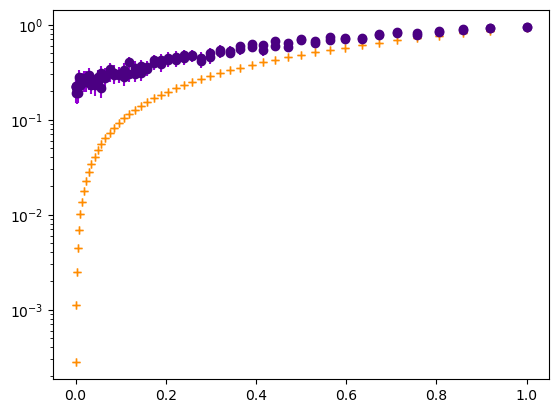

In [764]:
plt.plot(MI_enc, MI_phi, '+', color='darkorange')
plt.errorbar(x=MI_enc, y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
plt.yscale('log')
#plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-error-by-error-binsym-log.pdf')
plt.show()

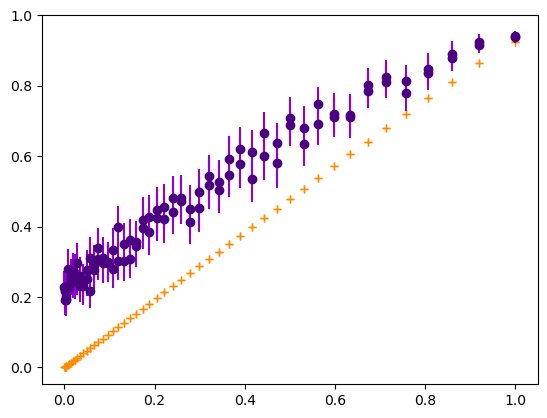

In [765]:
plt.plot(MI_enc, MI_phi, '+', color='darkorange')
plt.errorbar(x=MI_enc, y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
#plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-error-by-error-binsym-lin.pdf')
plt.show()

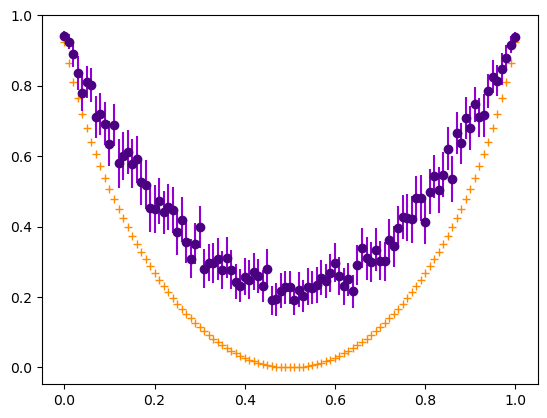

In [766]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
#plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-distortion-by-error-binsym.pdf')

## Varying Channel Distortion

In [768]:
resolution = 100
num_runs = 100

X1 = np.array([1, 0])
X2 = np.array([0, 1])

MI_phi = []
MI_sim = []



for err in np.linspace(0, 1, resolution + 1):

    channel = single_flip_channel(1, err)

    initial_state_x1 = X1
    initial_state_x2 = X2
    
    # Gillespie
    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    MI_sim_runs = []
    
    common_time = np.linspace(0, T, T+1)
    #interpolated_values_x1 = []
    #interpolated_values_x2 = []
#
    #for run_t, run_y in runs_x1:
    #    interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
    #    interpolated_values_x1.append(interp_func(common_time))
    #for run_t, run_y in runs_x2:
    #    interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
    #    interpolated_values_x2.append(interp_func(common_time))
#
    #interp_sim_arr_x1 = np.array(interpolated_values_x1)
    #interp_sim_arr_x2 = np.array(interpolated_values_x2)
#
    #for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
    #    sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
    #    sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
    #    MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
    
    for arr1, arr2 in tqdm(zip([tup[1] for tup in runs_x1], [tup[1] for tup in runs_x2])):
        sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
        sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
        MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs)) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs))
    
    #MI_sim_lower = MI_sim_means - MI_conf_int
    #MI_sim_higher = MI_sim_means + MI_conf_int

    #MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    #MI_sim_higher = np.clip(MI_sim_higher, 0, 1)

    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2]), X))
    MI_sim.append((MI_sim_means, MI_conf_int))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

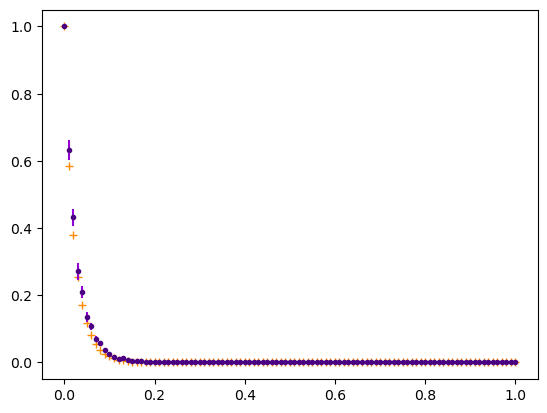

In [782]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='.',
            linestyle='none', color='indigo', ecolor='darkviolet')
#plt.yscale('log')
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-channel-binsym-lin.pdf')

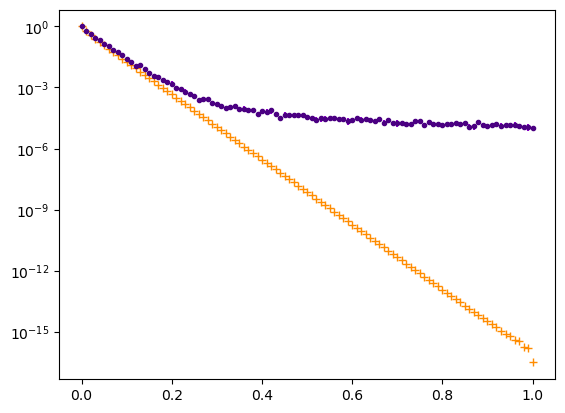

In [783]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='.',
            linestyle='none', color='indigo', ecolor='darkviolet')
plt.yscale('log')
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-channel-binsym-log.pdf')

# Mutual Information Binary Asymmetric

## Verying Encoding Performance

In [811]:
resolution = 100
channel = single_flip_channel(1, 0.001)
num_runs = 100

X1 = np.array([1, 0])
X2 = np.array([0, 1])

MI_enc = []
MI_phi = []
MI_sim = []



for err in np.linspace(0, 1, resolution + 1):

    E = bin_asym_channel(0.1, (0.1 - err) % 1)
    MI_enc.append(mutual_info(E, X))

    initial_state_x1 = E @ X1
    initial_state_x2 = E @ X2
    
    # Gillespie
    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    MI_sim_runs = []
    
    common_time = np.linspace(0, T, T+1)
    interpolated_values_x1 = []
    interpolated_values_x2 = []

    for run_t, run_y in runs_x1:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x1.append(interp_func(common_time))
    for run_t, run_y in runs_x2:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x2.append(interp_func(common_time))

    interp_sim_arr_x1 = np.array(interpolated_values_x1)
    interp_sim_arr_x2 = np.array(interpolated_values_x2)

    for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
        sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
        sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
        MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs)) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs))
    
    #MI_sim_lower = MI_sim_means - MI_conf_int
    #MI_sim_higher = MI_sim_means + MI_conf_int

    #MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    #MI_sim_higher = np.clip(MI_sim_higher, 0, 1)

    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2]), X))
    MI_sim.append((MI_sim_means, MI_conf_int))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



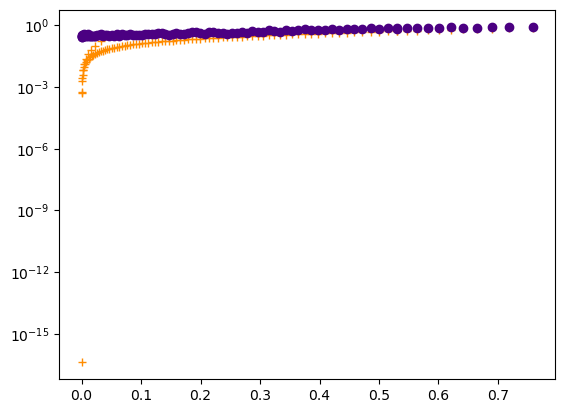

In [787]:
plt.plot(MI_enc, MI_phi, '+', color='darkorange')
plt.errorbar(x=MI_enc, y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
plt.yscale('log')
#plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-error-by-error-binasym-log.pdf')
plt.show()

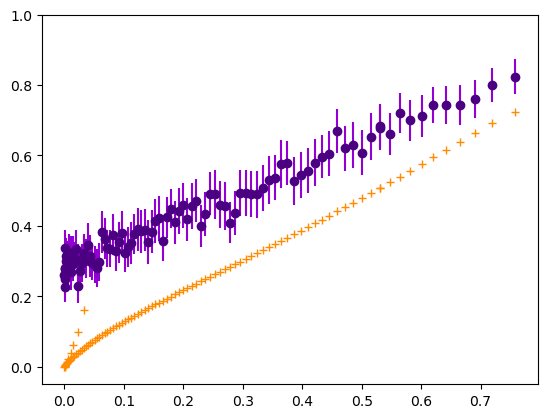

In [822]:
plt.plot(MI_enc, MI_phi, '+', color='darkorange')
plt.errorbar(x=MI_enc, y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
#plt.yscale('log')
plt.ylim(-0.05,1)
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-error-by-error-binasym-log.pdf')
plt.show()

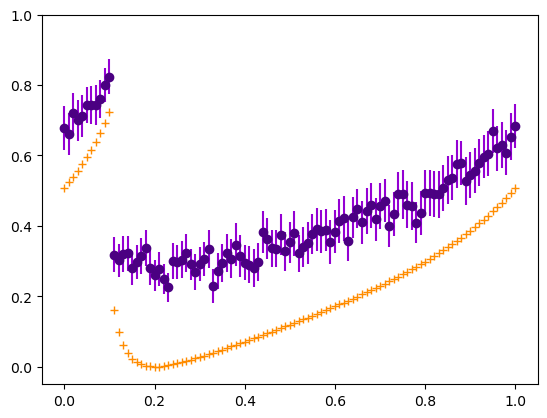

In [823]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='o',
            linestyle='none', color='indigo', ecolor='darkviolet')
plt.ylim(-0.05,1)
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-distortion-by-error-binasym.pdf')

# Varying Channel Distortion

In [797]:
resolution = 100
num_runs = 100

X1 = np.array([1, 0])
X2 = np.array([0, 1])

MI_enc = []
MI_phi = []
MI_sim = []



for err in np.linspace(0, 1, resolution + 1):

    channel = bin_asym_channel(0.1, (0.1 - err) % 1)

    initial_state_x1 = X1
    initial_state_x2 = X2
    
    # Gillespie
    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    MI_sim_runs = []
    
    common_time = np.linspace(0, T, T+1)
    interpolated_values_x1 = []
    interpolated_values_x2 = []

    for run_t, run_y in runs_x1:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x1.append(interp_func(common_time))
    for run_t, run_y in runs_x2:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x2.append(interp_func(common_time))

    interp_sim_arr_x1 = np.array(interpolated_values_x1)
    interp_sim_arr_x2 = np.array(interpolated_values_x2)

    for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
        sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
        sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
        MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs)) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs))
    
    #MI_sim_lower = MI_sim_means - MI_conf_int
    #MI_sim_higher = MI_sim_means + MI_conf_int

    #MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    #MI_sim_higher = np.clip(MI_sim_higher, 0, 1)

    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2]), X))
    MI_sim.append((MI_sim_means, MI_conf_int))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



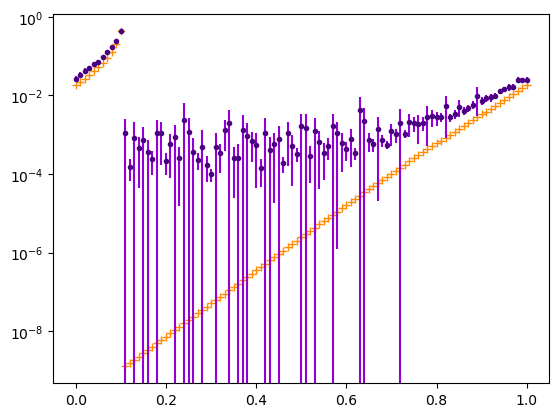

In [801]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='.',
            linestyle='none', color='indigo', ecolor='darkviolet')
plt.yscale('log')
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-channel-binasym-log.pdf')

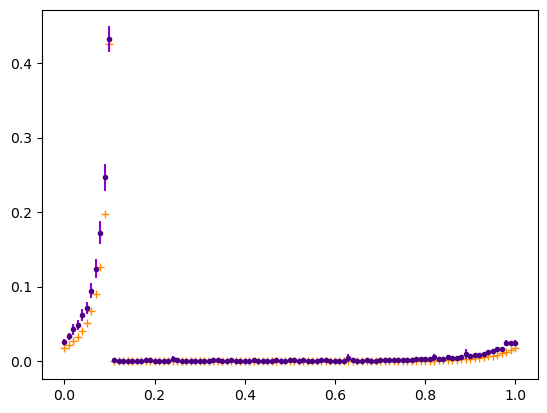

In [800]:
plt.plot(np.linspace(0, 1, 101), MI_phi, '+', color='darkorange')
plt.errorbar(x=np.linspace(0, 1, 101), y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='.',
            linestyle='none', color='indigo', ecolor='darkviolet')
#plt.yscale('log')
plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-channel-binasym-lin.pdf')

# Over Time with Perfect Encoding

In [134]:
MI_sim_runs = []
analytic_MI = []

analytical_time = None

num_runs = 100

X = [1/2, 1/2]

for channel in [single_flip_channel(1, 0.01)]:
    
    X1 = np.array([1, 0])
    X2 = np.array([0, 1])
    
    #E = single_flip_channel(1, 0.1)
    #    
    #initial_state_x1 = E @ X1
    #initial_state_x2 = E @ X2
    
    # Perfect Encoding
    initial_state_x1 = X1
    initial_state_x2 = X2

    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    common_time = np.linspace(0, T, T+1)
    interpolated_values_x1 = []
    interpolated_values_x2 = []

    for run_t, run_y in runs_x1:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x1.append(interp_func(common_time))
    for run_t, run_y in runs_x2:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x2.append(interp_func(common_time))

    interp_sim_arr_x1 = np.array(interpolated_values_x1)
    interp_sim_arr_x2 = np.array(interpolated_values_x2)

    for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
        MI_run = []
        for t in range(arr1.shape[0]):
            sim_phi_x1 = arr1[t]/np.sum(arr1[t])
            sim_phi_x2 = arr2[t]/np.sum(arr2[t])
            
            MI_run.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        MI_sim_runs.append(MI_run)
        
    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    analytical_time = analytic_curve_x1.t
    a
    for t in range(M1.shape[0]):
        phi_t_x1 = M1[t]/np.sum(M1[t])
        phi_t_x2 = M2[t]/np.sum(M2[t])
        
        analytic_MI.append(mutual_info(np.stack([phi_t_x1, phi_t_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs), axis=0) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs), axis=0)
    
    MI_sim_lower = MI_sim_means - MI_conf_int
    MI_sim_higher = MI_sim_means + MI_conf_int

    MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    MI_sim_higher = np.clip(MI_sim_higher, 0, 1)
       
    #sim_se = np.std(interp_sim_arr, axis=0) / np.sqrt(num_runs)
    #conf_int = 1.96 * sim_se

    #sim_lower = sim_means - conf_int
    #sim_higher = sim_means + conf_int

    #sim_lower = np.clip(sim_lower, 0, 1)
    #sim_higher = np.clip(sim_higher, 0, 1)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

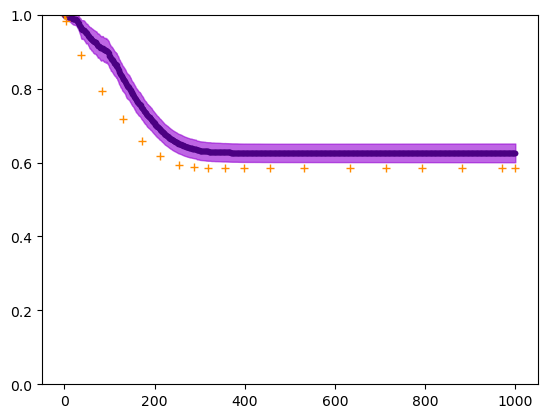

In [140]:
plt.plot(common_time, MI_sim_means, '.', color='indigo')
plt.fill_between(common_time, MI_sim_means, MI_sim_lower, alpha=0.6, color='darkviolet')
plt.fill_between(common_time, MI_sim_means, MI_sim_higher, alpha=0.6, color='darkviolet')
plt.plot(analytic_curve_x1.t, analytic_MI, '+', color='darkorange')
plt.yscale('linear')
plt.ylim(0,1)
#plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-pairs-over-time-wsim-binsym.pdf')

plt.show()

In [ ]:
# now do this for bin asym

In [805]:
MI_sim_runs = []
analytic_MI = []

analytical_time = None

num_runs = 100

X = [1/2, 1/2]

for channel in [bin_asym_channel(0.1, (0.1 - err) % 1)]:
    
    X1 = np.array([1, 0])
    X2 = np.array([0, 1])
    
    #E = single_flip_channel(1, 0.1)
    #    
    #initial_state_x1 = E @ X1
    #initial_state_x2 = E @ X2
    
    # Perfect Encoding
    initial_state_x1 = X1
    initial_state_x2 = X2

    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    common_time = np.linspace(0, T, T+1)
    interpolated_values_x1 = []
    interpolated_values_x2 = []

    for run_t, run_y in runs_x1:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x1.append(interp_func(common_time))
    for run_t, run_y in runs_x2:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x2.append(interp_func(common_time))

    interp_sim_arr_x1 = np.array(interpolated_values_x1)
    interp_sim_arr_x2 = np.array(interpolated_values_x2)

    for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
        MI_run = []
        for t in range(arr1.shape[0]):
            sim_phi_x1 = arr1[t]/np.sum(arr1[t])
            sim_phi_x2 = arr2[t]/np.sum(arr2[t])
            
            MI_run.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        MI_sim_runs.append(MI_run)
        
    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    analytical_time = analytic_curve_x1.t
    
    for t in range(M1.shape[0]):
        phi_t_x1 = M1[t]/np.sum(M1[t])
        phi_t_x2 = M2[t]/np.sum(M2[t])
        
        analytic_MI.append(mutual_info(np.stack([phi_t_x1, phi_t_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs), axis=0) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs), axis=0)
    
    MI_sim_lower = MI_sim_means - MI_conf_int
    MI_sim_higher = MI_sim_means + MI_conf_int

    MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    MI_sim_higher = np.clip(MI_sim_higher, 0, 1)
       
    #sim_se = np.std(interp_sim_arr, axis=0) / np.sqrt(num_runs)
    #conf_int = 1.96 * sim_se

    #sim_lower = sim_means - conf_int
    #sim_higher = sim_means + conf_int

    #sim_lower = np.clip(sim_lower, 0, 1)
    #sim_higher = np.clip(sim_higher, 0, 1)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

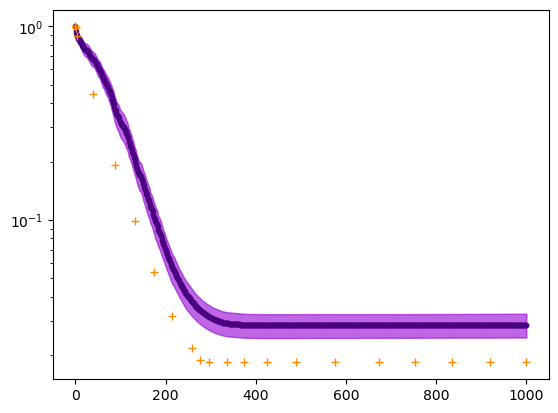

In [807]:
plt.plot(common_time, MI_sim_means, '.', color='indigo')
plt.fill_between(common_time, MI_sim_means, MI_sim_lower, alpha=0.6, color='darkviolet')
plt.fill_between(common_time, MI_sim_means, MI_sim_higher, alpha=0.6, color='darkviolet')
plt.plot(analytic_time, analytic_MI, '+', color='darkorange')
plt.yscale('log')

plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-pairs-over-time-wsim-binasym.pdf')

plt.show()

## TEST

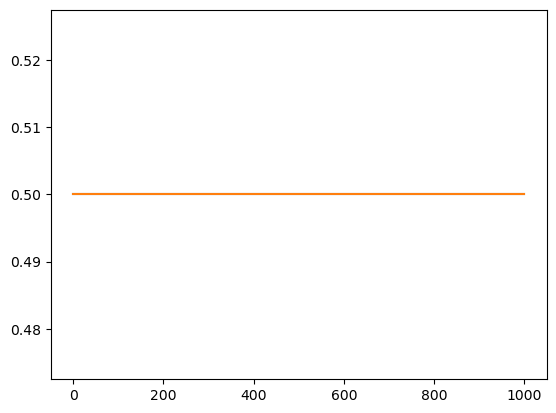

In [796]:

test_channel = single_flip_channel(1, 0.5)
test_mean_field = ODE(beta=beta, k=k, channel=test_channel, T=T)
test_analytic_curve = mean_field(initial_state=np.array([0.5,0.5])/N)

plt.plot(test_analytic_curve.t, [i/np.sum(i) for i in test_analytic_curve.y.T])

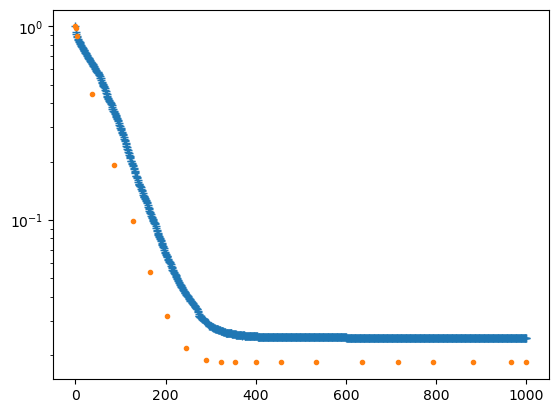

In [803]:
plt.plot(range(1001), MI_sim_means, '+')
plt.plot(analytical_time, analytic_MI, '.')
plt.yscale('log')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

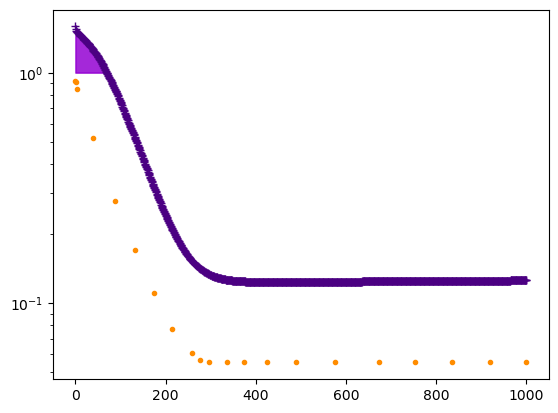

In [702]:
MI_sim_runs = []
analytic_MI = []

analytical_time = None

num_runs = 1000

X = [1/3,1/3,1/3]

for channel in [simplex_channel(3, 0.1)]:
    
    X1 = np.array([1, 0, 0])
    X2 = np.array([0, 1, 0])
    X3 = np.array([0, 0, 1])
    
    #E = simplex_channel(3, 0.1)
    #    
    #initial_state_x1 = E @ X1
    #initial_state_x2 = E @ X2
    #initial_state_x3 = E @ X3
    
    # Perfect Encoding
    initial_state_x1 = X1
    initial_state_x2 = X2
    initial_state_x3 = X3
    

    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))
        
    runs_x3 = list()
    for _ in tqdm(range(num_runs)):

        sim_x3 = NoisyGillespie(N=N, initial_state=initial_state_x3, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x3.simulate(max_time=T, density=True)
        runs_x3.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    common_time = np.linspace(0, T, T+1)
    interpolated_values_x1 = []
    interpolated_values_x2 = []
    interpolated_values_x3 = []

    for run_t, run_y in runs_x1:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x1.append(interp_func(common_time))
    for run_t, run_y in runs_x2:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x2.append(interp_func(common_time))
    for run_t, run_y in runs_x3:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
        interpolated_values_x3.append(interp_func(common_time))

    interp_sim_arr_x1 = np.array(interpolated_values_x1)
    interp_sim_arr_x2 = np.array(interpolated_values_x2)
    interp_sim_arr_x3 = np.array(interpolated_values_x3)

    for arr1, arr2, arr3 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2, interp_sim_arr_x3)):
        MI_run = []
        for t in range(arr1.shape[0]):
            sim_phi_x1 = arr1[t]/np.sum(arr1[t])
            sim_phi_x2 = arr2[t]/np.sum(arr2[t])
            sim_phi_x3 = arr3[t]/np.sum(arr3[t])
            
            MI_run.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2, sim_phi_x3]), X))
        MI_sim_runs.append(MI_run)
        
    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)
    analytic_curve_x3 = mean_field(initial_state=initial_state_x3/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    M3 = analytic_curve_x3.y.T
    
    analytical_time = analytic_curve_x1.t
    
    for t in range(M1.shape[0]):
        phi_t_x1 = M1[t]/np.sum(M1[t])
        phi_t_x2 = M2[t]/np.sum(M2[t])
        phi_t_x3 = M2[t]/np.sum(M3[t])
        
        analytic_MI.append(mutual_info(np.stack([phi_t_x1, phi_t_x2, phi_t_x3]), X))
        
    MI_se = np.std(np.array(MI_sim_runs), axis=0) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs), axis=0)
    
    MI_sim_lower = MI_sim_means - MI_conf_int
    MI_sim_higher = MI_sim_means + MI_conf_int

    MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    MI_sim_higher = np.clip(MI_sim_higher, 0, 1)
    
    plt.plot(common_time, MI_sim_means, '+', color='indigo')
    plt.fill_between(common_time, MI_sim_means, MI_sim_lower, alpha=0.6, color='darkviolet')
    plt.fill_between(common_time, MI_sim_means, MI_sim_higher, alpha=0.6, color='darkviolet')
    plt.plot(analytic_time, analytic_MI, '.', color='darkorange')
    plt.yscale('log')

    plt.savefig('/home/sagar/modeling-info-spread/reports/figures/mutual-info-triangle-over-time-wsim.pdf')

    plt.show()

In [ ]:
resolution = 100
channel = single_flip_channel(1, 0.001)

X1 = np.array([1, 0])
X2 = np.array([0, 1])

MI_enc = []
MI_phi = []



for err in np.linspace(0, 1, resolution + 1):

    E = single_flip_channel(1, err)
    MI_enc.append(mutual_info(E, X))

    initial_state_x1 = E @ X1
    initial_state_x2 = E @ X2

    # Mean Field    
    mean_field_x1 = ODE(beta=beta, k=k, channel=channel, T=T)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2]), X))

# New Figures

In [ ]:
# No more phase diagram--all on S with simulations and red empty circles for the info spreading and markov cases

In [76]:
final_bin_sym_mc = [l[0][2][-1] for l in mean_gillespie_results.get('bin_sym').values()]

In [87]:
final_bin_sym_mf = [l[0][1][-1] for l in mean_field_results.get('bin_sym').values()]

In [88]:
final_bin_sym_mc, final_bin_sym_mf

([array([0.99710742, 0.        ]),
  array([1., 0.]),
  array([0.99847946, 0.        ]),
  array([1., 0.]),
  array([1., 0.]),
  array([0.99746587, 0.        ]),
  array([1., 0.]),
  array([9.53585675e-01, 2.74842458e-04]),
  array([0.99476932, 0.00425358]),
  array([0.92366283, 0.06083868]),
  array([0.70831436, 0.26248915]),
  array([0.5796152 , 0.40590839]),
  array([0.53656041, 0.45779672]),
  array([0.50841154, 0.48672663]),
  array([0.50537704, 0.49495381]),
  array([0.50380996, 0.49761257]),
  array([0.50217834, 0.49944837]),
  array([0.20331753, 0.50214363]),
  array([0.50097408, 0.49195145]),
  array([0.49895834, 0.50265747]),
  array([0.502611  , 0.49702723]),
  array([0.50074206, 0.50077025]),
  array([0.45151086, 0.50042736]),
  array([0.50163918, 0.5011702 ]),
  array([0.50096925, 0.50251433]),
  array([0.50101551, 0.50226126]),
  array([0.49969352, 0.50179037]),
  array([0.50085871, 0.50020024]),
  array([0.501377  , 0.50092966]),
  array([0.50154655, 0.50049701])],
 [arr

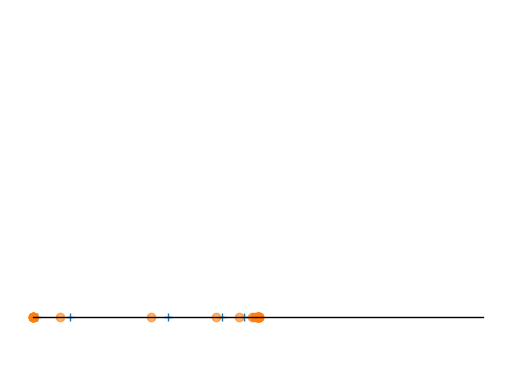

In [98]:
plt.plot([y for x,y in final_bin_sym_mf], [0]*len(final_bin_sym_mf), '+', alpha=1)
plt.plot([y for x,y in final_bin_sym_mc], [0]*len(final_bin_sym_mf), 'o', alpha=0.6)
plt.xlim(-0.05,1.05)
plt.ylim(-0.01, 0.05)
plt.gca().axis('off')
plt.plot([0, 1], [0, 0], 'k-', linewidth=1)

In [ ]:
# need more

In [ ]:
#fig, axs = plt.subplots(1, 3, figsize=(9, 2))

#colormap = plt.cm.plasma # set colormap

bin_sym_100 = defaultdict(dict)
bin_asym_100 = defaultdict(dict)

N = 10e4

for n,name in enumerate(['bin_sym', 'bin_asym']):\
    
    common_time = np.linspace(0, T, T+1)
    
    for e in range(100):
        
        err = e/100
        
        if name == 'bin_sym':
            channel = single_flip_channel(1, err)
            d = bin_sym_100
        elif name == 'bin_asym':
            channel = bin_asym_channel(0.1, (err - 0.1) % 1)
            d = bin_asym_100
        else: 
            raise ValueError
            
            
        initial_state = np.array([1,0])
        
        # Mean Field    
        mean_field = ODE(beta=beta, k=k, channel=channel, T=T,t_eval=common_time)
        analytic_curve = mean_field(initial_state=initial_state/N)
        
        d["{:2f}".format(err)]['mean_field'] = analytic_curve
        
        
        #axs[n].plot(inst[:, 0], inst[:, 1], linestyle='dotted', color='k')
        
        # Simulation
        runs = list()
        for _ in tqdm(range(100)):
            
            sim = NoisyGillespie(N=N, initial_state=initial_state, beta=beta, k=k, 
                                channel=channel)
            test_sim = sim.simulate(max_time=T, density=True)
            runs.append((test_sim[0], test_sim[1]))
                                     
        # Interpolating Gillespie Means
        interpolated_values = []
        
        for run_t, run_y in runs:
            interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
            interpolated_values.append(interp_func(common_time))
        
        interp_sim_arr = np.array(interpolated_values)
        sim_means = np.mean(interp_sim_arr, axis=0)
        sim_se = np.std(interp_sim_arr, axis=0) / np.sqrt(num_runs)
        conf_int = 1.96 * sim_se

        sim_lower = sim_means - conf_int
        sim_higher = sim_means + conf_int

        sim_lower = np.clip(sim_lower, 0, 1)
        sim_higher = np.clip(sim_higher, 0, 1)
        
        d["{:2f}".format(err)]['gillespie'] = (common_time, sim_means, sim_lower, sim_higher) 

    
# setup the colorbar
#normalize = mcolors.Normalize(vmin=0, vmax=1)
#scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
#scalarmappaple.set_array([i/100 for i in range(100)])
#plt.colorbar(scalarmappaple, ax=axs, label=r'$\epsilon$')

#fig.savefig('/home/sagar/modeling-info-spread/reports/figures/continuous_phase_space_1d.pdf')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [609]:
final_bin_sym_mc = [(err, bin_sym_100.get(err).get('gillespie')[1][-1]) for err in bin_sym_100.keys()]

final_bin_sym_mf = [(err, bin_sym_100.get(err).get('mean_field').y.T[-1]) for err in bin_sym_100.keys()]

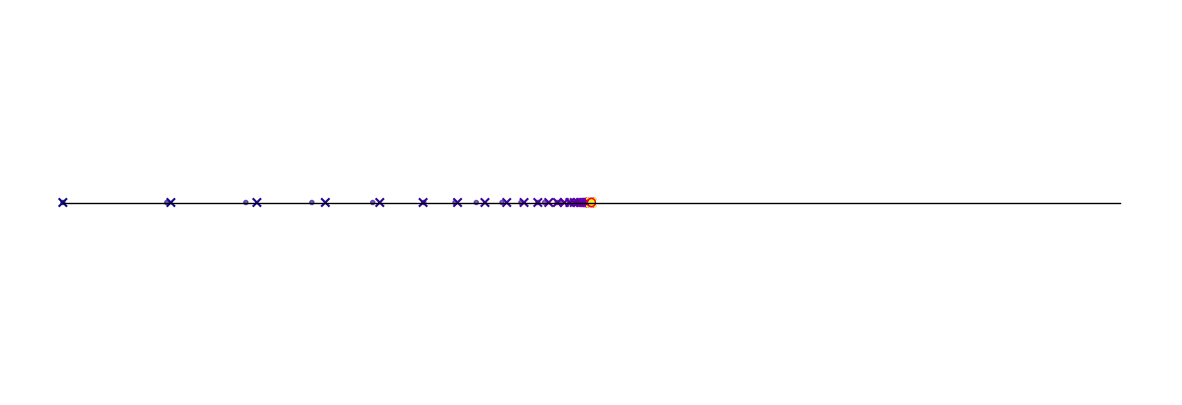

In [632]:
colormap = plt.cm.plasma # set colormap
colors = colormap([float(t) for t,y in final_bin_sym_mf])

plt.figure(figsize=(15,5))
plt.scatter([y[1] for t,y in final_bin_sym_mf], [0]*len(final_bin_sym_mf), marker='x', alpha=1, 
         c=colors)
plt.scatter([y[1] for t,y in final_bin_sym_mc], [0]*len(final_bin_sym_mc), marker='.', alpha=0.6,
        c=colors)
plt.scatter([0.5], [0], marker='o', facecolors='none', edgecolors='r')
plt.xlim(-0.05,1.05)
plt.ylim(-0.01, 0.01)
plt.gca().axis('off')
plt.plot([0, 1], [0, 0], 'k-', linewidth=1)
plt.show()

In [124]:
# All cases of I by e with separate lines for delta going from 0 to 1
# Include the markov chain 
# Include the max line
# Should encoding channel be the same channel or the |A|-ary channel ? Need to make it clear that regardless, information 
# is the same

In [144]:
arr = np.array([[1,2,3], [4,5,6]])
for n,a in enumerate(arr):
    print(n, a)

0 [1 2 3]
1 [4 5 6]


In [296]:
1e4

10000.0

In [786]:
def run_MI(Q: npt.NDArray[np.float64],
           E: npt.NDArray[np.float64],
           pW: npt.NDArray[np.float64] = None,
           N: int = 10e3,
           beta: float = 0.01,
           k: int = 4, 
           cmap: list = plt.cm.plasma,
           num_runs: int =100,
           T = 1000,
           run_simulations=True,
           run_mean_field=True,
           run_random_walk=True,
           run_si=True):
    
    """
    Runs Gillespie and Mean Field 
    """
    
    output = {}
    
    MI_sim_runs = []
    analytic_MI = []
    rw_MI = []
    si_MI = []
    MI_sim_lower = []
    MI_sim_higher = []
    
    
    common_time = np.linspace(0, T, int(T/20) + 1)
    output['time'] = common_time
    

    #E = single_flip_channel(1, 0.1)
    #    
    #initial_state_x1 = E @ X1
    #initial_state_x2 = E @ X2
    
    if pW is None:
        pW = np.array([1/Q.shape[0]]*Q.shape[0])
    else:
        pW = pW
    
    # array true states
    Omega = np.eye(Q.shape[0])

    # Initial States (Row Vectors)
    phi0_arr = E @ Omega

    # Noisy Gillespie Algorithm
    if run_simulations:
        runs = []
        for n,row in enumerate(phi0_arr):

            runs_n = []

            for _ in tqdm(range(num_runs), desc=f"Simulating Message {n}"):

                sim = NoisyGillespie(N=N, initial_state=row, beta=beta, k=k, 
                                channel=Q)
                run = sim.simulate(max_time=T, density=True)
                runs_n.append(run)            
            runs.append(runs_n)

        # Interpolating Gillespie Means
        interpolated_values = []

        for runs_n in runs:
            interp_vals_n = []
            for run_t, run_y in runs_n:
                interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0)
                interp_vals_n.append(interp_func(common_time))
            interpolated_values.append(np.array(interp_vals_n))

        for arrs in zip(*interpolated_values):
            MI_run = []
            for n,t in enumerate(common_time):
                sim_phis = []
                for arr in arrs:
                    sim_phi = arr[n]/np.sum(arr[n])
                    sim_phis.append(sim_phi)
                MI_run.append(mutual_info(np.stack(sim_phis), pW))
            MI_sim_runs.append(MI_run)


        MI_se = np.std(np.array(MI_sim_runs), axis=0) / np.sqrt(num_runs)
        MI_conf_int = 1.96 * MI_se

        MI_sim_means = np.mean(np.array(MI_sim_runs), axis=0)
        output['mc_means'] = MI_sim_means

        MI_sim_lower = MI_sim_means - MI_conf_int
        MI_sim_higher = MI_sim_means + MI_conf_int

        MI_sim_lower = np.clip(MI_sim_lower, 0, np.log2(Q.shape[0]))
        MI_sim_higher = np.clip(MI_sim_higher, 0, np.log2(Q.shape[0]))
        output['mc_lower_ci'] = MI_sim_lower
        output['mc_upper_ci'] = MI_sim_higher
    
    

    # Numerical Approximations    
    mean_field = ODE(beta=beta, k=k, channel=Q, T=T, t_eval=common_time)
    
    analytic_curves = []
    
    random_walks = []
    
    SIs = []
    
    
    time_stamps = None
    for row in phi0_arr:
        if run_mean_field:
            analytic_curve = mean_field(initial_state=row/N)
            analytic_curves.append(analytic_curve)
        
        if run_random_walk:
            random_walk = mean_field(initial_state=row/N, function='RW')
            random_walks.append(random_walk)
        
        if run_si:
            SI = mean_field(initial_state=row/N, function='SI')
            SIs.append(SI)
    
    #interp_mean_field_values = []
    #for curve in analytic_curves:
    #    interp_func = interp1d(curve.t, curve.y.T, kind='linear', fill_value='extrapolate', axis=0)
    #    interp_mean_field_values.append(interp_func(common_time))   
    #
    for n,t in enumerate(common_time):
        if run_mean_field:
            try:
                phi_t = []
                for curve in analytic_curves:
                    message = curve.y.T
                    phi_n = message[n]/np.sum(message[n])
                    phi_t.append(phi_n)
                analytic_MI.append(mutual_info(np.stack(phi_t), pW))
            except IndexError:
                analytic_MI.append(0)
            
        
        if run_random_walk:
            try:
                phi_t_rw = []
                for rw in random_walks:
                    message = rw.y.T
                    phi_n = message[n]/np.sum(message[n])
                    phi_t_rw.append(phi_n)
                rw_MI.append(mutual_info(np.stack(phi_t_rw), pW))
            except IndexError:
                rw_MI.append(0)
        
        if run_si:
            try:
                phi_t_si = []
                for si in SIs:
                    message = si.y.T
                    phi_n = message[n]/np.sum(message[n])
                    phi_t_si.append(phi_n)
                si_MI.append(mutual_info(np.stack(phi_t_si), pW))
            except IndexError:
                si_MI.append(0)
    

    if run_mean_field:
        output['mean_field'] = analytic_MI
    
    if run_random_walk:
        output['markov_chain'] = rw_MI
        
    if run_si:
        output['SI'] = si_MI

    
        
    return output

In [ ]:
# Calculating mean message dynamics *then* mutual information, not mean mutual information

def run_MI(Q: npt.NDArray[np.float64],
           E: npt.NDArray[np.float64],
           pW: npt.NDArray[np.float64] = None,
           N: int = 10e3,
           beta: float = 0.01,
           k: int = 4, 
           cmap: list = plt.cm.plasma,
           num_runs: int =100,
           T = 1000,
           run_simulations=True,
           run_mean_field=True,
           run_random_walk=True,
           run_si=True):
    
    """
    Runs Gillespie and Mean Field 
    """
    
    output = {}
    
    MI_sim_runs = []
    analytic_MI = []
    rw_MI = []
    si_MI = []
    MI_sim_lower = []
    MI_sim_higher = []
    
    
    common_time = np.linspace(0, T, int(T/20) + 1)
    output['time'] = common_time
    

    #E = single_flip_channel(1, 0.1)
    #    
    #initial_state_x1 = E @ X1
    #initial_state_x2 = E @ X2
    
    if pW is None:
        pW = np.array([1/Q.shape[0]]*Q.shape[0])
    else:
        pW = pW
    
    # array true states
    Omega = np.eye(Q.shape[0])

    # Initial States (Row Vectors)
    phi0_arr = E @ Omega

    # Noisy Gillespie Algorithm
    if run_simulations:
        runs = []
        for n,row in enumerate(phi0_arr):

            runs_n = []

            for _ in tqdm(range(num_runs), desc=f"Simulating Message {n}"):

                sim = NoisyGillespie(N=N, initial_state=row, beta=beta, k=k, 
                                channel=Q)
                run = sim.simulate(max_time=T, density=True)
                runs_n.append(run)            
            runs.append(runs_n)

        # Interpolating Gillespie Means
        interpolated_values = []

        for runs_n in runs:
            interp_vals_n = []
            for run_t, run_y in runs_n:
                interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0)
                interp_vals_n.append(interp_func(common_time))
            interpolated_values.append(np.array(interp_vals_n))
            
        mean_trajectories = [np.mean(interpolated_values[0], axis=0), np.mean(interpolated_values[1], axis=0)]
        
        # for 95% we actually should calculate the most possible and the least possible
        lower_trajectories = [np.percentile(interpolated_values[0], 2.5, axis=0), 
                             np.percentile(interpolated_values[0], 2.5, axis=0)]
        upper_trajectories = [np.percentile(interpolated_values[0], 97.5, axis=0), 
                             np.percentile(interpolated_values[0], 97.5, axis=0)]

        for seed in zip(*mean_trajectories):
            sim_phis = []
            for n,t in enumerate(common_time):
                sim_phi = seed[n]/np.sum(seed[n])
                sim_phis.append(sim_phi)
            MI_sim_runs.append(mutual_info(np.stack(sim_phis), pW))


        MI_se = np.std(np.array(MI_sim_runs), axis=0) / np.sqrt(num_runs)
        MI_conf_int = 1.96 * MI_se

        MI_sim_means = np.mean(np.array(MI_sim_runs), axis=0)
        output['mc_means'] = MI_sim_means

        MI_sim_lower = MI_sim_means - MI_conf_int
        MI_sim_higher = MI_sim_means + MI_conf_int

        MI_sim_lower = np.clip(MI_sim_lower, 0, np.log2(Q.shape[0]))
        MI_sim_higher = np.clip(MI_sim_higher, 0, np.log2(Q.shape[0]))
        output['mc_lower_ci'] = MI_sim_lower
        output['mc_upper_ci'] = MI_sim_higher
    
    

    # Numerical Approximations    
    mean_field = ODE(beta=beta, k=k, channel=Q, T=T, t_eval=common_time)
    
    analytic_curves = []
    
    random_walks = []
    
    SIs = []
    
    
    time_stamps = None
    for row in phi0_arr:
        if run_mean_field:
            analytic_curve = mean_field(initial_state=row/N)
            analytic_curves.append(analytic_curve)
        
        if run_random_walk:
            random_walk = mean_field(initial_state=row/N, function='RW')
            random_walks.append(random_walk)
        
        if run_si:
            SI = mean_field(initial_state=row/N, function='SI')
            SIs.append(SI)
    
    #interp_mean_field_values = []
    #for curve in analytic_curves:
    #    interp_func = interp1d(curve.t, curve.y.T, kind='linear', fill_value='extrapolate', axis=0)
    #    interp_mean_field_values.append(interp_func(common_time))   
    #
    for n,t in enumerate(common_time):
        if run_mean_field:
            try:
                phi_t = []
                for curve in analytic_curves:
                    message = curve.y.T
                    phi_n = message[n]/np.sum(message[n])
                    phi_t.append(phi_n)
                analytic_MI.append(mutual_info(np.stack(phi_t), pW))
            except IndexError:
                analytic_MI.append(0)
            
        
        if run_random_walk:
            try:
                phi_t_rw = []
                for rw in random_walks:
                    message = rw.y.T
                    phi_n = message[n]/np.sum(message[n])
                    phi_t_rw.append(phi_n)
                rw_MI.append(mutual_info(np.stack(phi_t_rw), pW))
            except IndexError:
                rw_MI.append(0)
        
        if run_si:
            try:
                phi_t_si = []
                for si in SIs:
                    message = si.y.T
                    phi_n = message[n]/np.sum(message[n])
                    phi_t_si.append(phi_n)
                si_MI.append(mutual_info(np.stack(phi_t_si), pW))
            except IndexError:
                si_MI.append(0)
    

    if run_mean_field:
        output['mean_field'] = analytic_MI
    
    if run_random_walk:
        output['markov_chain'] = rw_MI
        
    if run_si:
        output['SI'] = si_MI

    
        
    return output

In [764]:
eps_to_test = [0.01, 0.06]
dlt_to_test = [0, 0.04]
channel_toplogies = ['bin_sym', 'bin_asym', 'triangle', 'cherry', 'paw']

MI_by_t_plots = {}

for top in channel_toplogies:
    
    MI_by_t_plots[top] = {}
    
    for eps in eps_to_test:
        
        for dlt in dlt_to_test:
            
        
            if top=='bin_sym':
                Q = single_flip_channel(1, eps)
                E = single_flip_channel(1, dlt)
                
            elif top=='bin_asym':
                Q = bin_asym_channel(0.01, (eps-0.01) % 1)
                E = single_flip_channel(1, dlt)
            
            elif top=='triangle':
                Q = simplex_channel(3, eps)
                E = simplex_channel(3, dlt)
                
            elif top=='cherry':
                Q = star_channel(3, eps)
                E = simplex_channel(3, dlt)
                
            elif top=='paw':
                Q = paw_channel(eps)
                E = simplex_channel(4, dlt)
                
            else:
                raise ValueError
                
            MI = run_MI(Q=Q, E=E, num_runs=100, N=10e4)
            
            MI_by_t_plots[top][(round(eps,2), round(dlt,2))] = MI

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 2:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 2:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 2:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 2:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 2:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [413]:
test_MI = run_MI(Q=single_flip_channel(1, 0.01), E=single_flip_channel(1, 0.001), num_runs=100, N=10e4)

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/sagar/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2123276/2622593711.py", line 1, in <module>
    test_MI = run_MI(Q=single_flip_channel(1, 0.01), E=single_flip_channel(1, 0.001), num_runs=100, N=10e4)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2123276/20995001.py", line 60, in run_MI
    run = sim.simulate(max_time=T, density=True)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagar/modeling-info-spread/src/models/continuous_models.py", line 92, in simulate
    np.sum(self.state) <= self.N):  # As long as not everybody has been infected
        ^^^^^^^^^^^
  File "/home/sagar/modeling-info-spread/src/models/continuous_models.py", line 62, in step
  File "<__array_function__ internals>", line 200, in search

(0.0, 1.0)

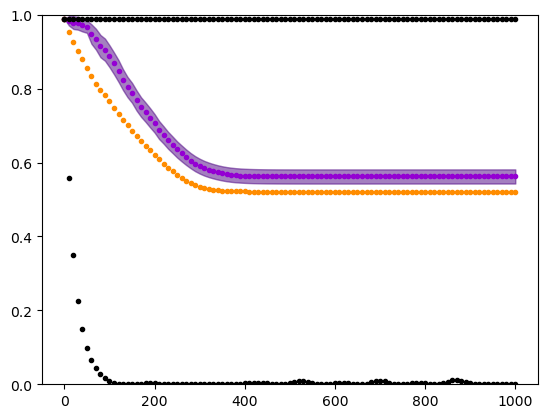

In [331]:
plt.plot(test_MI['time'], test_MI['mc_means'], marker='.', linestyle='None', color='darkviolet')
plt.fill_between(test_MI['time'], test_MI['mc_lower_ci'], test_MI['mc_upper_ci'], alpha=0.5, color='indigo')
plt.plot(test_MI['time'], test_MI['mean_field'], marker='.', linestyle='None', color='darkorange')
plt.plot(test_MI['time'], test_MI['markov_chain'], marker='.', color='k', linestyle='None')
plt.plot(test_MI['time'], test_MI['SI'], marker='.', color='k', linestyle='None')



In [327]:
test_MI_large_N = run_MI(Q=single_flip_channel(1, 0.01), E=single_flip_channel(1, 0.001), num_runs=100, N=10e4)

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def 

(0.0, 1.0)

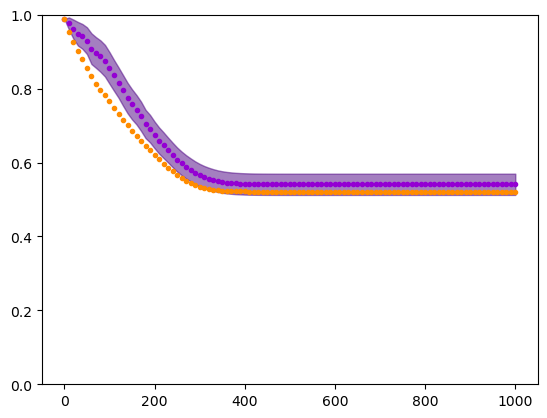

In [329]:
plt.plot(test_MI_large_N['time'], test_MI_large_N['mc_means'], marker='.', linestyle='None', color='darkviolet')
plt.fill_between(test_MI_large_N['time'], test_MI_large_N['mc_lower_ci'], test_MI_large_N['mc_upper_ci'], alpha=0.5, color='indigo')
plt.plot(test_MI_large_N['time'], test_MI_large_N['mean_field'], marker='.', linestyle='None', color='darkorange')
plt.ylim(0,1)

(0.0, 1.0)

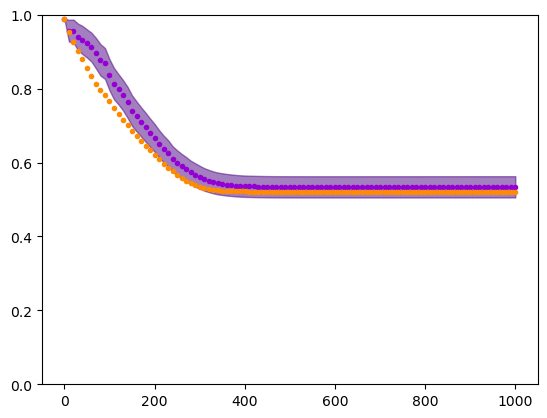

In [42]:
plt.plot(test_MI_large_N[0], test_MI_large_N[1], marker='.', linestyle='None', color='darkviolet')
plt.fill_between(test_MI_large_N[0], test_MI_large_N[2], test_MI_large_N[3], alpha=0.5, color='indigo')
plt.plot(test_MI_large_N[0], test_MI_large_N[-1], marker='.', linestyle='None', color='darkorange')
plt.ylim(0,1)

In [339]:
test_asym = run_MI(Q=bin_asym_channel(0.001, (err - 0.001) % 1), E=single_flip_channel(1, 0.001), num_runs=100)

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

(0.0, 1.0)

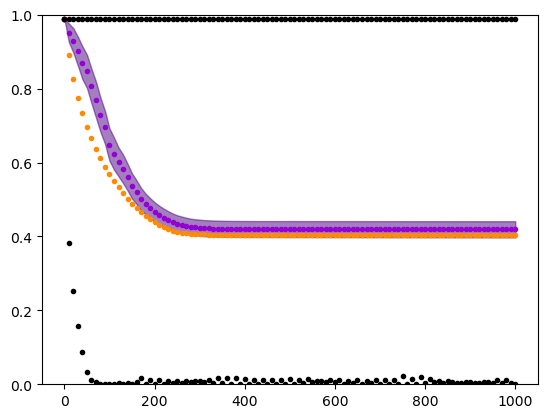

In [341]:
plt.plot(test_asym['time'], test_asym['mc_means'], marker='.', linestyle='None', color='darkviolet')
plt.fill_between(test_asym['time'], test_asym['mc_lower_ci'], test_asym['mc_upper_ci'], alpha=0.5, color='indigo')
plt.plot(test_asym['time'], test_asym['mean_field'], marker='.', linestyle='None', color='darkorange')
plt.plot(test_asym['time'], test_asym['markov_chain'], marker='.', color='k', linestyle='None')
plt.plot(test_asym['time'], test_asym['SI'], marker='.', color='k', linestyle='None')
plt.ylim(0,1)

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

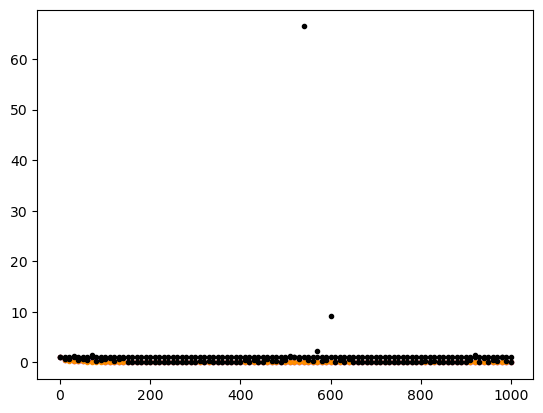

In [740]:
test_asym_noisy = run_MI(Q=bin_asym_channel(0.01, (err - 0.01) % 1), E=single_flip_channel(1, 0.001), num_runs=100, N=10e4)
plt.plot(test_asym_noisy['time'], test_asym_noisy['mc_means'], marker='.', linestyle='None', color='darkviolet')
plt.fill_between(test_asym_noisy['time'], test_asym_noisy['mc_lower_ci'], test_asym_noisy['mc_upper_ci'], alpha=0.5, color='indigo')
plt.plot(test_asym_noisy['time'], test_asym_noisy['mean_field'], marker='.', linestyle='None', color='darkorange')
plt.plot(test_asym_noisy['time'], test_asym_noisy['markov_chain'], marker='.', color='k', linestyle='None')
plt.plot(test_asym_noisy['time'], test_asym_noisy['SI'], marker='.', color='k', linestyle='None')


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 2:   0%|          | 0/100 [00:00<?, ?it/s]

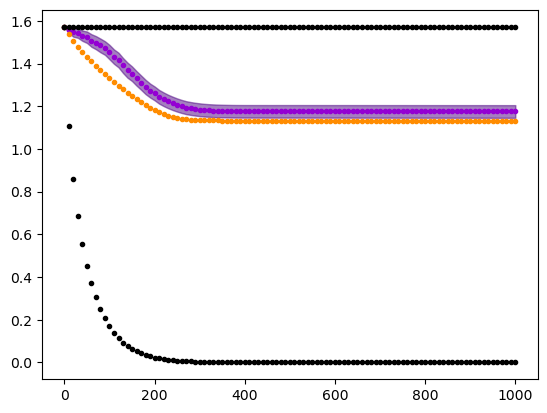

In [358]:
test_cherry = run_MI(Q=star_channel(3, 0.01), E=simplex_channel(3, 0.001), num_runs=100, N=10e3)
plt.plot(test_cherry['time'], test_cherry['mc_means'], marker='.', linestyle='None', color='darkviolet')
plt.fill_between(test_cherry['time'], test_cherry['mc_lower_ci'], test_cherry['mc_upper_ci'], alpha=0.5, color='indigo')
plt.plot(test_cherry['time'], test_cherry['mean_field'], marker='.', linestyle='None', color='darkorange')
plt.plot(test_cherry['time'], test_cherry['markov_chain'], marker='.', color='k', linestyle='None')
plt.plot(test_cherry['time'], test_cherry['SI'], marker='.', color='k', linestyle='None')

In [ ]:
with open('/data_users1/sagar/modeling-info-spread/pickles/heatmap_test_bs.pkl', 'wb') as f_hm:
    pickle.dump(MI_heatmap_bs, f_hm)

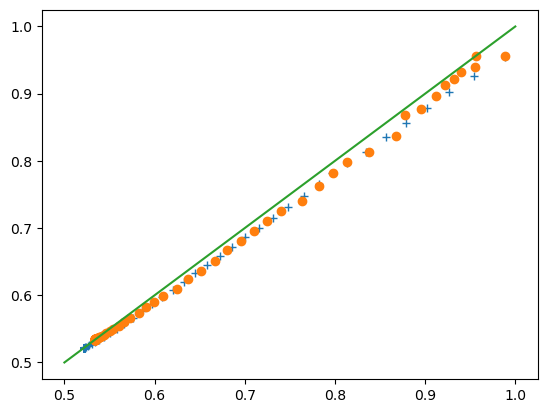

In [53]:
it = test_MI_large_N[-1][:-1]
it1 = test_MI_large_N[-1][1:]

itsim = test_MI_large_N[1][:-1]
itsim1 = test_MI_large_N[1][1:]



plt.plot(it, it1, '+')
plt.plot(itsim, itsim1, 'o')
plt.plot(np.linspace(0.5, 1, 20), np.linspace(0.5, 1, 20))

In [ ]:
MI_by_err = {}
for err in np.linspace(0,1,101):
    print(f"eps = {err}")
    MI_by_err[round(err, 2)] = run_MI(Q=single_flip_channel(1, err), 
                                      E=np.eye(2), num_runs=100, N=10e4)

eps = 0.0


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.01


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.02


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.03


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.04


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.05


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.06


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

In [56]:
with open('/data_users1/sagar/modeling-info-spread/pickles/MI_bin_sym.pkl', 'wb') as f_mibs:
    pickle.dump(MI_by_err, f_mibs)

In [89]:
MI_by_err_asym = {}
for err in np.linspace(0,1,101):
    print(f"eps = {err}")
    MI_by_err_asym[round(err, 2)] = run_MI(Q=bin_asym_channel(0.1, (err - 0.1) % 1), 
                                      E=np.eye(2), num_runs=100, N=10e4)

eps = 0.0


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.01


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.02


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.03


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.04


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.05


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

eps = 0.06


Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/sagar/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2123276/3098379285.py", line 4, in <module>
    MI_by_err_asym[round(err, 2)] = run_MI(Q=bin_asym_channel(0.1, (err - 0.1) % 1),
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2123276/2767377248.py", line 48, in run_MI
    run = sim.simulate(max_time=T, density=True)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagar/modeling-info-spread/src/models/continuous_models.py", line 92, in simulate
    if not self.step():
           ^^^^^^^^^^^
  File "/home/sagar/modeling-info-spread/src/models/continuous_models.py", line -1, in step
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sagar/anaconda3/lib/p

In [ ]:
# MI by t fits better with a lil bit of error in E

## Paper Plots

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

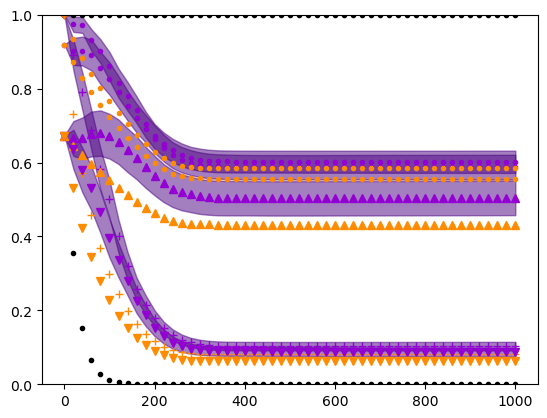

In [840]:
bin_sim_MIT = {0.01: {}, 0.06: {}}

bin_sim_MIT[0.01][0] = run_MI(Q=single_flip_channel(1, 0.01), E=single_flip_channel(1,0), num_runs=100, N=10e3)
bin_sim_MIT[0.06][0] = run_MI(Q=single_flip_channel(1, 0.06), E=single_flip_channel(1,0), num_runs=100, N=10e3)
bin_sim_MIT[0.01][0.06] = run_MI(Q=single_flip_channel(1, 0.01), E=single_flip_channel(1,0.06), num_runs=100, N=10e3)
bin_sim_MIT[0.06][0.06] = run_MI(Q=single_flip_channel(1, 0.06), E=single_flip_channel(1,0.06), num_runs=100, N=10e3)

plt.plot(test_MI_large_N['time'], test_MI_large_N['mc_means'], marker='.', linestyle='None', color='darkviolet')
plt.fill_between(test_MI_large_N['time'], test_MI_large_N['mc_lower_ci'], test_MI_large_N['mc_upper_ci'], alpha=0.5, color='indigo')
plt.plot(test_MI_large_N['time'], test_MI_large_N['mean_field'], marker='.', linestyle='None', color='darkorange')
plt.ylim(0,1)


plt.plot(bin_sim_MIT[0.01][0]['time'], bin_sim_MIT[0.01][0]['mc_means'], marker='.', 
         linestyle='None', color='darkviolet')
plt.fill_between(bin_sim_MIT[0.01][0]['time'], bin_sim_MIT[0.01][0]['mc_lower_ci'], 
                 bin_sim_MIT[0.01][0]['mc_upper_ci'], alpha=0.5, color='indigo')
plt.plot(bin_sim_MIT[0.01][0]['time'], bin_sim_MIT[0.01][0]['mean_field'], 
         marker='.', linestyle='None', color='darkorange')

plt.plot(bin_sim_MIT[0.06][0]['time'], bin_sim_MIT[0.06][0]['mc_means'], marker='+', 
         linestyle='None', color='darkviolet')
plt.fill_between(bin_sim_MIT[0.06][0]['time'], bin_sim_MIT[0.06][0]['mc_lower_ci'], 
                 bin_sim_MIT[0.06][0]['mc_upper_ci'], alpha=0.5, color='indigo')
plt.plot(bin_sim_MIT[0.06][0]['time'], bin_sim_MIT[0.06][0]['mean_field'], 
         marker='+', linestyle='None', color='darkorange')


plt.plot(bin_sim_MIT[0.01][0.06]['time'], bin_sim_MIT[0.01][0.06]['mc_means'], marker='^', 
         linestyle='None', color='darkviolet')
plt.fill_between(bin_sim_MIT[0.01][0.06]['time'], bin_sim_MIT[0.01][0.06]['mc_lower_ci'], 
                 bin_sim_MIT[0.01][0.06]['mc_upper_ci'], alpha=0.5, color='indigo')
plt.plot(bin_sim_MIT[0.01][0.06]['time'], bin_sim_MIT[0.01][0.06]['mean_field'], 
         marker='^', linestyle='None', color='darkorange')

plt.plot(bin_sim_MIT[0.06][0.06]['time'], bin_sim_MIT[0.06][0.06]['mc_means'], marker='v', 
         linestyle='None', color='darkviolet')
plt.fill_between(bin_sim_MIT[0.06][0.06]['time'], bin_sim_MIT[0.06][0.06]['mc_lower_ci'], 
                 bin_sim_MIT[0.06][0.06]['mc_upper_ci'], alpha=0.5, color='indigo')
plt.plot(bin_sim_MIT[0.06][0.06]['time'], bin_sim_MIT[0.06][0.06]['mean_field'], 
         marker='v', linestyle='None', color='darkorange')

In [796]:
test_2 = run_MI(Q=single_flip_channel(1, 0.01), E=single_flip_channel(1,0.06), num_runs=100, N=10e3)

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

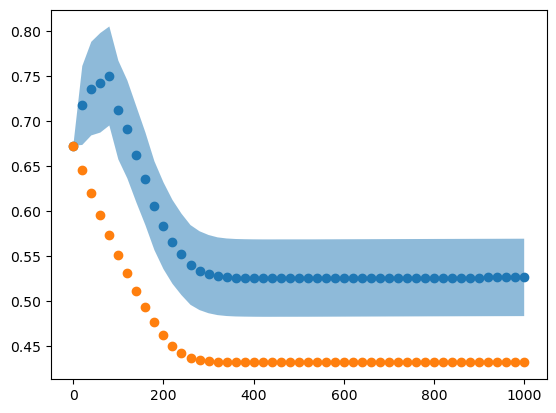

In [797]:
plt.plot(test_2['time'], test_2['mc_means'], 'o')
plt.plot(test_2['time'], test_2['mean_field'], 'o')
plt.fill_between(test_2['time'], test_2['mc_lower_ci'], test_2['mc_upper_ci'], alpha=0.5)

In [782]:
mutual_info(single_flip_channel(1,0.01), np.array([1/2,1/2]))

0.9192068641040888

In [781]:
estimate_capacity(single_flip_channel(1,0.08))

(0.5978208097977272, array([0.5, 0.5]))

### Issue testing

In [845]:
test_runs = []
test0_arr = single_flip_channel(1,0.06) @ np.eye(2)
for n,row in enumerate(test0_arr):

    test_runs_n = []

    for _ in tqdm(range(num_runs), desc=f"Simulating Message {n}"):

        sim = NoisyGillespie(N=10e4, initial_state=row, beta=beta, k=k, 
                        channel=single_flip_channel(1,0.01))
        test_run = sim.simulate(max_time=T, density=True)
        test_runs_n.append(test_run)            
    test_runs.append(test_runs_n)

Simulating Message 0:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Message 1:   0%|          | 0/100 [00:00<?, ?it/s]

In [846]:
# Interpolating Gillespie Means
test_interpolated_values = []
test_common_time = np.linspace(0, T, int(T/20) + 1)

for test_runs_n in test_runs:
    interp_vals_n = []
    for run_t, run_y in test_runs_n:
        interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0)
        interp_vals_n.append(interp_func(test_common_time))
    test_interpolated_values.append(np.array(interp_vals_n))

In [847]:
np.mean(test_interpolated_values[0], axis=0).shape

(51, 2)

In [848]:
test_mean_trajectories = [np.mean(test_interpolated_values[0], axis=0), np.mean(test_interpolated_values[1], axis=0)]
test_MI_sim = []
for test_seed in zip(*test_mean_trajectories):
    sim_phis = []
    for seed in test_seed:
        sim_phi = seed/np.sum(seed)
        sim_phis.append(sim_phi)
    test_MI_sim.append(mutual_info(np.stack(sim_phis), [1/2,1/2]))

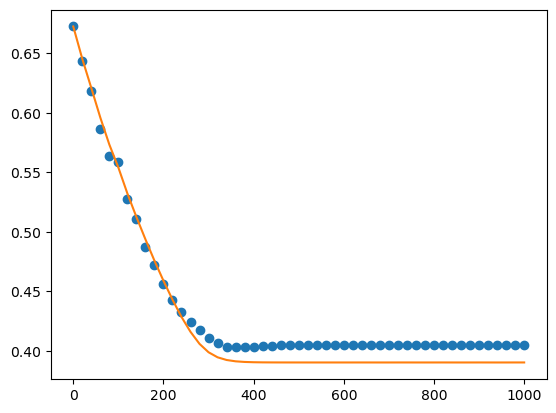

In [849]:
test_mf = run_MI(Q=single_flip_channel(1, 0.01), E=single_flip_channel(1,0.06), num_runs=100, N=10e4,
                run_simulations=False, run_si=False, run_random_walk=False)
plt.plot(test_common_time, test_MI_sim, 'o')
plt.plot(test_common_time, test_mf['mean_field'])

# Heatmap

In [517]:
np.finfo(float).eps

2.220446049250313e-16

In [489]:
color_norm = LogNorm(vmin=10e-16, vmax=1) # min is on the order of machine eps

In [490]:
def heatmap(Q: Callable,
            E: Callable,
            pW: npt.NDArray[np.float64] = None,
            T: int = 1000,
            N: int = 10e3,
            beta: float = 0.01,
            k: int = 4):
    
    """
    Returns MI value of a communication process occurring over the channels specified.
    """
    if pW is None:
        pW = np.array([1/Q.shape[0]]*Q.shape[0])
    else:
        pW = pW
    
    # array true states
    Omega = np.eye(Q.shape[0])

    # Initial States (Row Vectors)
    phi0_arr = E @ Omega
    
    mean_field = ODE(beta=beta, k=k, channel=Q, T=T, t_eval=np.linspace(0, T, int(T/10) + 1))
    
    analytic_curves = []
    
    for row in phi0_arr:
        analytic_curve = mean_field(initial_state=row/N)
        analytic_curves.append(analytic_curve)
    
    phi_t = []
    for curve in analytic_curves:
        final_message = curve.y.T[-1]
        phi_n = final_message/np.sum(final_message)
        phi_t.append(phi_n)
        
    return mutual_info(np.stack(phi_t), pW)

In [518]:
MI_hm_bs = np.zeros((101,101))

for n,eps in tqdm(enumerate(np.linspace(0,1,101))):
    for m,dlt in enumerate(np.linspace(0,1,101)):
        MI_hm_bs[n,m] = heatmap(Q=single_flip_channel(1,eps), E=single_flip_channel(1,dlt))


0it [00:00, ?it/s]

Text(0.5, 23.52222222222222, 'Currently $\\delta$ but will become $C(\\mathcal{E})$ maybe')

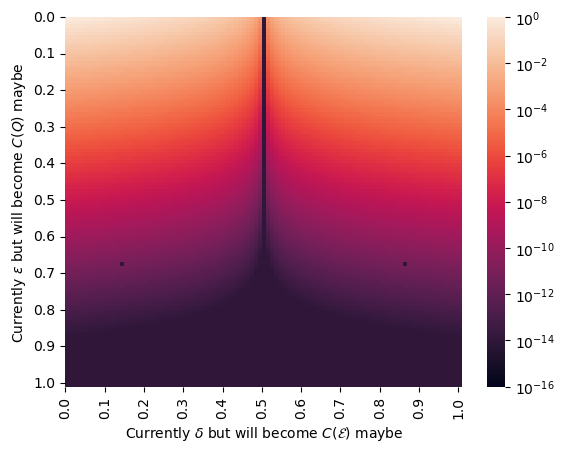

In [519]:
# Setting zero to a very small positive for the log norm colormap
MI_hm_bs[MI_hm_bs < 10e-15] = 10e-15

sns.heatmap(MI_hm_bs, norm=color_norm)
ticks = np.arange(0, len(x), 10)  # Indices for every 10th label
plt.xticks(ticks, labels=np.round(x[ticks], 2))
plt.yticks(ticks, labels=np.round(x[ticks], 2))

plt.ylabel(r'Currently $\epsilon$ but will become $C(Q)$ maybe')
plt.xlabel(r'Currently $\delta$ but will become $C(\mathcal{E})$ maybe')

In [520]:
MI_hm_cherry = np.zeros((101,101))

for n,eps in tqdm(enumerate(np.linspace(0,1,101))):
    for m,dlt in enumerate(np.linspace(0,1,101)):
        MI_hm_cherry[n,m] = heatmap(Q=star_channel(3,eps), E=simplex_channel(3,dlt))


0it [00:00, ?it/s]

Text(0.5, 23.52222222222222, 'Currently $\\delta$ but will become $C(\\mathcal{E})$ maybe')

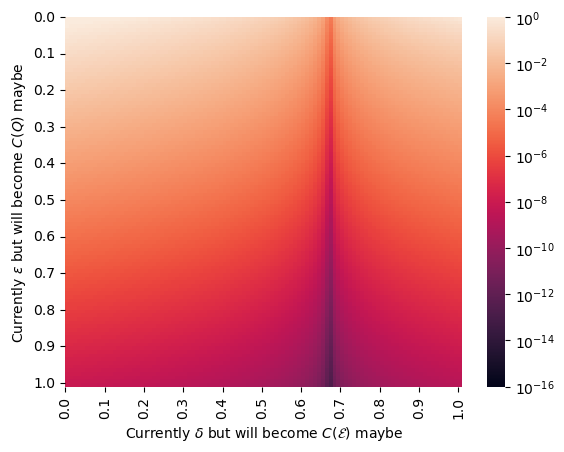

In [521]:
# Setting zero to a very small positive for the log norm colormap
MI_hm_cherry[MI_hm_cherry < 10e-15] = 10e-15

sns.heatmap(MI_hm_cherry, norm=color_norm)

ticks = np.arange(0, len(x), 10)  # Indices for every 10th label
plt.xticks(ticks, labels=np.round(x[ticks], 2))
plt.yticks(ticks, labels=np.round(x[ticks], 2))

plt.ylabel(r'Currently $\epsilon$ but will become $C(Q)$ maybe')
plt.xlabel(r'Currently $\delta$ but will become $C(\mathcal{E})$ maybe')

In [522]:
MI_hm_triangle = np.zeros((101,101))

for n,eps in tqdm(enumerate(np.linspace(0,1,101))):
    for m,dlt in enumerate(np.linspace(0,1,101)):
        MI_hm_triangle[n,m] = heatmap(Q=simplex_channel(3,eps), E=simplex_channel(3,dlt))

MI_hm_triangle[MI_hm_triangle < 10e-16]

0it [00:00, ?it/s]

array([9.04142408e-16, 6.64459233e-16, 5.71627682e-16, 4.33706618e-16,
       3.82471649e-16, 3.38695933e-16, 8.29188647e-16, 2.07297169e-16,
       5.04096726e-16, 1.43821003e-16, 4.36660354e-16, 7.35714686e-17,
       4.73859250e-16, 1.89652071e-16, 2.16088356e-16, 1.69701381e-16,
       9.53337308e-16, 3.33501391e-16, 1.90156234e-16, 7.46710514e-16,
       8.00551328e-16, 2.87547734e-16, 1.43074192e-16, 7.40864070e-16])

Text(0.5, 23.52222222222222, 'Currently $\\delta$ but will become $C(\\mathcal{E})$ maybe')

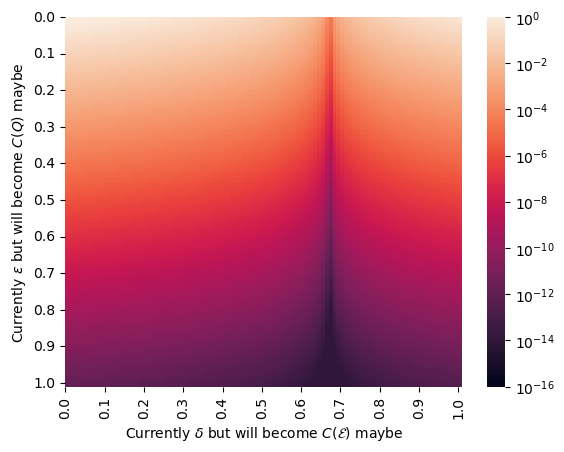

In [523]:
# Setting zero to a very small positive for the log norm colormap
MI_hm_triangle[MI_hm_triangle < 10e-15] = 10e-15

sns.heatmap(MI_hm_triangle, norm=color_norm)

ticks = np.arange(0, len(x), 10)  # Indices for every 10th label
plt.xticks(ticks, labels=np.round(x[ticks], 2))
plt.yticks(ticks, labels=np.round(x[ticks], 2))

plt.ylabel(r'Currently $\epsilon$ but will become $C(Q)$ maybe')
plt.xlabel(r'Currently $\delta$ but will become $C(\mathcal{E})$ maybe')


In [513]:
MI_hm_bin_asym = np.zeros((101,101))

for n,eps in tqdm(enumerate(np.linspace(0,1,101))):
    for m,dlt in enumerate(np.linspace(0,1,101)):
        MI_hm_bin_asym[n,m] = heatmap(Q=bin_asym_channel(0.01, (err - eps) % 1), E=single_flip_channel(1, dlt))

MI_hm_bin_asym[MI_hm_bin_asym < 10e-16]d

0it [00:00, ?it/s]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Text(0.5, 23.52222222222222, 'Currently $\\delta$ but will become $C(\\mathcal{E})$ maybe')

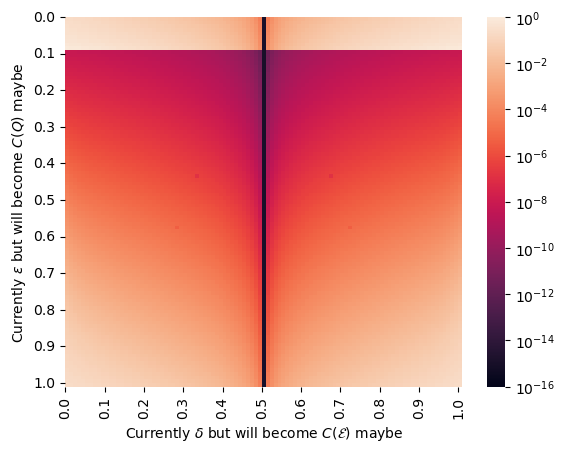

In [514]:
# Setting zero to a very small positive for the log norm colormap
MI_hm_bin_asym[MI_hm_bin_asym < 10e-15] = 10e-15

sns.heatmap(MI_hm_bin_asym, norm=color_norm)

ticks = np.arange(0, len(x), 10)  # Indices for every 10th label
plt.xticks(ticks, labels=np.round(x[ticks], 2))
plt.yticks(ticks, labels=np.round(x[ticks], 2))

plt.ylabel(r'Currently $\epsilon$ but will become $C(Q)$ maybe')
plt.xlabel(r'Currently $\delta$ but will become $C(\mathcal{E})$ maybe')


In [438]:
MI_heatmap_bs = {}
for eps in tqdm(np.linspace(0,1,101)):
    MI_heatmap_bs[eps] = {}
    for dlt in np.linspace(0,1,101):
        MI_heatmap_bs[eps][dlt] = run_MI(Q=single_flip_channel(1, eps), E=single_flip_channel(1, dlt), num_runs=100, N=10e3,
                                         run_simulations=False, run_random_walk=False, run_si=False)

  0%|          | 0/101 [00:00<?, ?it/s]

In [439]:
MI_heatmapp_arr = np.zeros((101,101))
x_labels = []
y_labels = []
for n,key in enumerate(MI_heatmap_bs.keys()):
    y_labels.append(key)
    for m, key2 in enumerate(MI_heatmap_bs[key].keys()):
        x_labels.append(round(key2, 2))
        MI_heatmapp_arr[(n,m)] = MI_heatmap_bs[key][key2]['mean_field'][-1]

!pip install --upgrade seaborn

([<matplotlib.axis.YTick at 0x7f9d4c80b550>,
 [Text(0, 0, '0.0'),
  Text(0, 10, '0.1'),
  Text(0, 20, '0.2'),
  Text(0, 30, '0.3'),
  Text(0, 40, '0.4'),
  Text(0, 50, '0.5'),
  Text(0, 60, '0.6'),
  Text(0, 70, '0.7'),
  Text(0, 80, '0.8'),
  Text(0, 90, '0.9'),
  Text(0, 100, '1.0')])

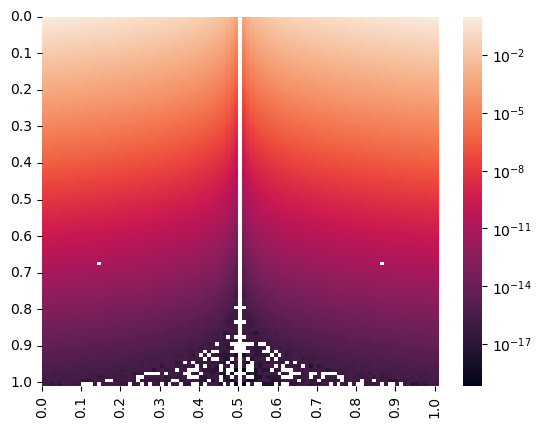

In [440]:
sns.heatmap(MI_heatmapp_arr,norm=LogNorm())
x = np.linspace(0,1,101)
ticks = np.arange(0, len(x), 10)  # Indices for every 10th label
plt.xticks(ticks, labels=np.round(x[ticks], 2))
plt.yticks(ticks, labels=np.round(x[ticks], 2))

# Figuring out the equation

In [296]:
beta, k

(0.01, 4)

In [307]:
def RW(t, x):
    return (single_flip_channel(1,0.01) - np.eye(2)) @ x
rw_solve = solve_ivp(fun=RW, t_span=[1,1000], y0=np.array(np.array([1/N,0])))

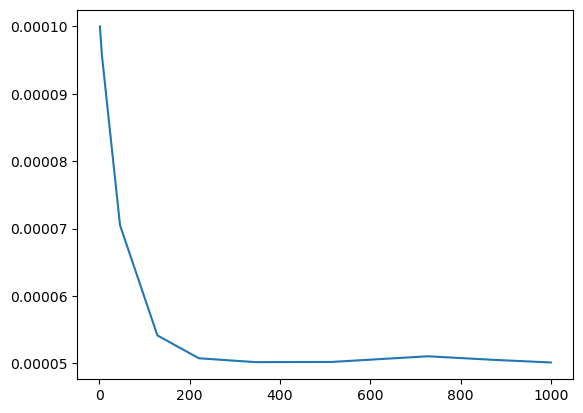

In [308]:
plt.plot(rw_solve.t, rw_solve.y[0])

In [397]:
capbs = -1 * (0.01*np.log2(0.01) + 0.99*np.log2(0.99))
capbs

0.08079313589591118

In [396]:
2**0.08

1.0570180405613803

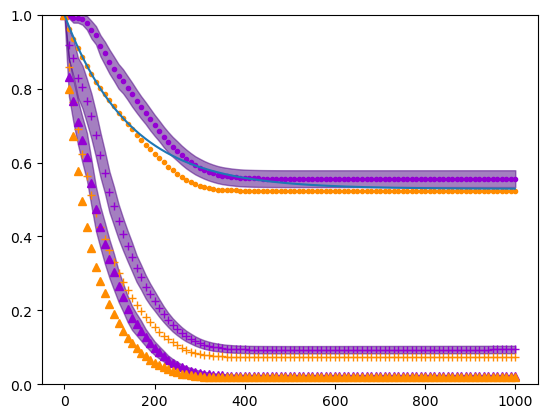

In [761]:
for err, marker in zip([0.01, 0.05, 0.08], ['.', '+', '^']):
    tup = MI_by_err.get(err)
    plt.plot(tup[0], tup[1], marker=marker, linestyle='None', color='darkviolet')
    plt.fill_between(tup[0], tup[2], tup[3], alpha=0.5, color='indigo')
    plt.plot(tup[0], tup[-1], marker=marker, linestyle='None', color='darkorange')

plt.ylim(0,1)

#this discrete one works really well as an approximation
#plt.plot(np.linspace(0, 1000, 101), [(1 - MI_by_err.get(0.01)[-1][n-1])*np.exp(-0.01*(t-1)) + MI_by_err.get(0.01)[-1][n-1] for n,t in enumerate(np.linspace(0, 1000, 101))], 
#         color='blbeta_ack')

#plt.plot(range(1000), 
#         [(1-2**(-1*mutual_info(single_flip_channel(1,0.01), [1/2,1/2])))*np.exp(-0.007*t) + 2**(-1*mutual_info(single_flip_channel(1,0.01), [1/2,1/2])) 
#         for t in range(1000)],
#        color='green')

mibs = mutual_info(single_flip_channel(1,0.01), [1/2,1/2])
capbs = -1 * (0.01*np.log2(0.01) + 0.99*np.log2(0.99))
plt.plot(range(1000),
        [(1-2**(-1*mibs))*2**(-1*0.01*t)+2**(-1*mibs) for t in range(1000)])


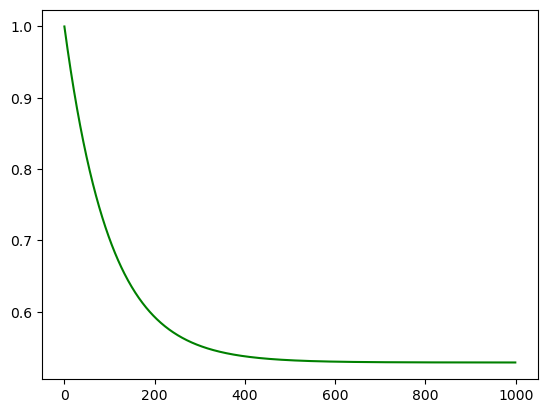

In [231]:
plt.plot(range(1000), 
         [(1-2**(-1*mutual_info(single_flip_channel(1,0.01), [1/2,1/2])))*np.exp(-0.01*t) + 2**(-1*mutual_info(single_flip_channel(1,0.01), [1/2,1/2])) 
         for t in range(1000)],
        color='green')

In [217]:
.9192068641040888-1

-0.0807931358959112

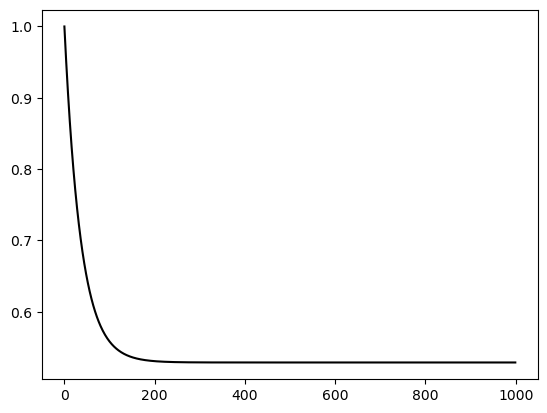

In [102]:
plt.plot(range(1000), [(1-2**-0.9192068641040888)*2**(-0.04*t) + 2**-0.9192068641040888 for t in range(1000)], color='black')

In [96]:
2**-0.9192068641040888

0.5287996532339944

In [ ]:
# I(t) - I(t+1) plot?

Text(0, 0.5, '$I(t+dt)$')

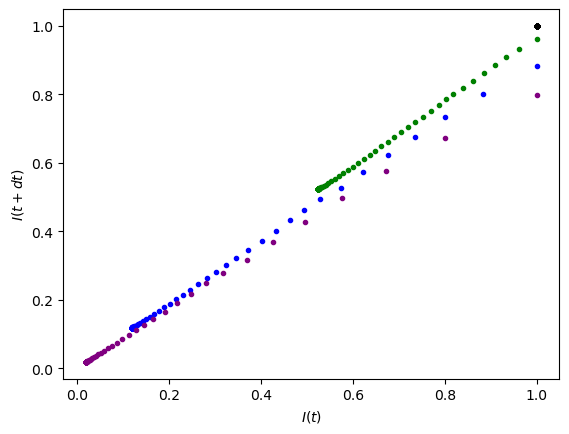

In [312]:
plt.plot(MI_by_err.get(0.00)[-1][:-1],MI_by_err.get(0.00)[-1][1:], '.', color='black')
plt.plot(MI_by_err.get(0.01)[-1][:-1],MI_by_err.get(0.01)[-1][1:], '.', color='green')
plt.plot(MI_by_err.get(0.04)[-1][:-1],MI_by_err.get(0.04)[-1][1:], '.',color='blue')
#plt.plot(MI_by_err.get(0.05)[-1][:-1],MI_by_err.get(0.05)[-1][1:], '.',color='purple')
plt.plot(MI_by_err.get(0.08)[-1][:-1],MI_by_err.get(0.08)[-1][1:], '.',color='purple')
plt.xlabel(r'$I(t)$')
plt.ylabel(r'$I(t+dt)$')

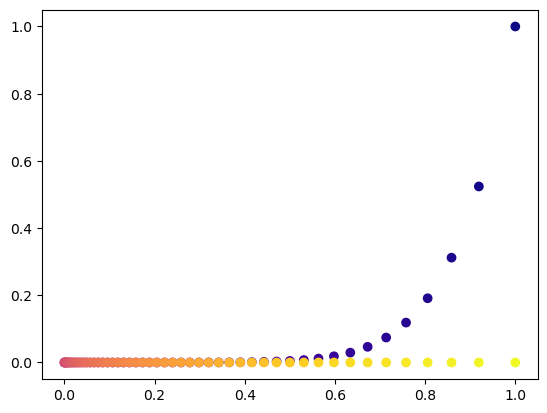

In [80]:
pt_colors = [plt.cm.plasma(err) for err in MI_by_err.keys()]
plt.scatter([mutual_info(single_flip_channel(1,err), np.array([1/2,1/2])) for err in MI_by_err.keys()],
        [tup[-1][-1] for tup in MI_by_err.values()], marker='o', c=pt_colors)

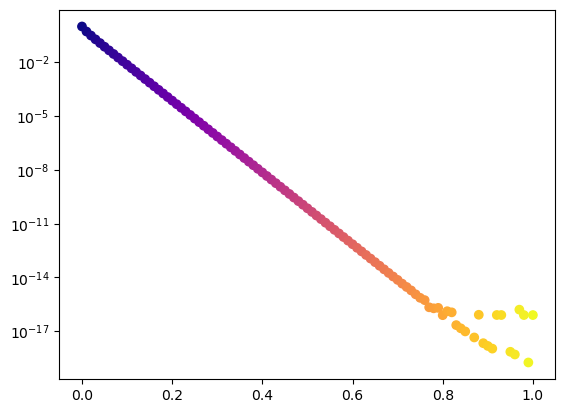

In [634]:
plt.scatter(MI_by_err.keys(),[tup[-1][-1] for tup in MI_by_err.values()], marker='o', c=pt_colors)
plt.yscale('log')

In [88]:
MI_by_err.get(0.01)[-1][-1]

0.5238534816063982

In [74]:
mutual_info(single_flip_channel(1,0.01), np.array([1/2,1/2]))

0.9192068641040888

In [ ]:
def test_fun(t, mi):
    return (1 - mi)*np.exp(-0.01*t) 

test_solve = solve_ivp(fun=test_fun, t_span=[1,1000], y0=np.array([1]))

In [283]:
def pi_fun(t, pi):
    I = (0.0001*np.exp(0.04*t)/(1 + 0.0001*(np.exp(0.04*t)-1)))
    return 0.04 *(1 - I)*single_flip_channel(1, 0.01) @ pi

pi_solve = solve_ivp(fun=pi_fun, t_span=[1,1000], y0=np.array(np.array([1,0])))

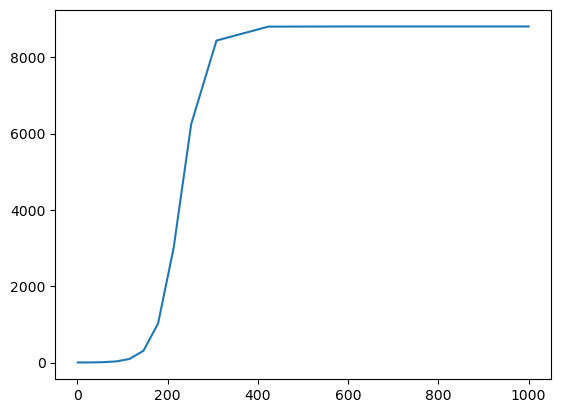

In [284]:
plt.plot(pi_solve.t, pi_solve.y[0])

In [194]:
plt.plot(range(1000), [(1-mi)*np.exp(-0.01*t)/(1 - np.exp(-0.01*t)) for t in range(1000)])

NameError: name 'mi' is not defined

In [135]:
# (NEW) Sample the effect of changing the encoding so that different messages are the majority | fix Q but also do one for 
# e=0 as the information spreading model & say that we're being generous bc otherwise the info would always be maximized
# Also add that that the source coding theorem sets this as the max

In [ ]:
# (Already have) show that for all errors, the majority seeded stays the majority
# (This means showing the phase diagrams and shoving the full plots to the appdx)

In [ ]:
# (Already have) Show the information between encoding and final 
# (NEW) include the line for information spreading models (Q = 0)

## Estimating Channel Capacity

In [526]:
from scipy.optimize import minimize

In [530]:
test_Q = single_flip_channel(1,0.01)

# Function to minimize
def objective(px, Q):
    return -mutual_info(Q, px)

# Initial guess for input distribution P(X)
px0 = np.array([0.3, 0.7])  

# Constraints: probabilities must sum to 1
constraints = ({'type': 'eq', 'fun': lambda px: np.sum(px) - 1})

# Bounds: each probability must be between 0 and 1
bounds = [(0, 1), (0, 1)]

# Optimize to find the input distribution that maximizes mutual information
result = minimize(objective, px0, args=(test_Q,), bounds=bounds, constraints=constraints, method='SLSQP')

# Channel capacity is the negative of the minimized result
channel_capacity = -result.fun
optimal_px = result.x

channel_capacity, optimal_px

(0.9192065334548756, array([0.49965457, 0.50034543]))

In [531]:
1 - (-1*(0.99*np.log2(0.99) + 0.01*np.log2(0.01)))

0.9192068641040888

In [536]:
def objective(px, Q):
    return -mutual_info(Q, px)

def estimate_capacity(Q):
    # Initial guess for input distribution P(X)
    px0 = np.array([1/Q.shape[0]]*Q.shape[0])  

    # Constraints: probabilities must sum to 1
    constraints = ({'type': 'eq', 'fun': lambda px: np.sum(px) - 1})

    # Bounds: each probability must be between 0 and 1
    bounds = [(0, 1)]*Q.shape[0]

    # Optimize to find the input distribution that maximizes mutual information
    result = minimize(objective, px0, args=(Q,), bounds=bounds, constraints=constraints, method='SLSQP')

    # Channel capacity is the negative of the minimized result
    channel_capacity = -result.fun
    optimal_px = result.x

    return channel_capacity, optimal_px

In [547]:
estimate_capacity(star_channel(3, 0.5))

(0.4999999962747098, array([7.45058071e-09, 4.99999996e-01, 4.99999996e-01]))

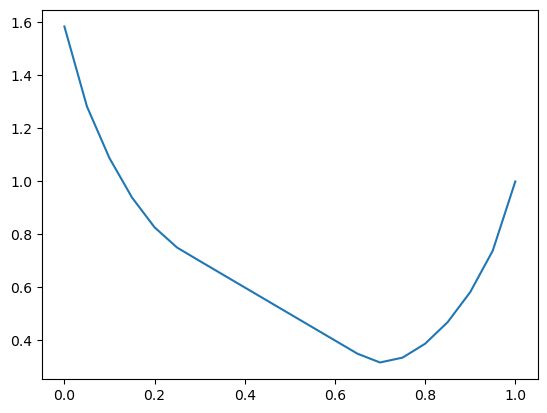

In [549]:
plt.plot(np.linspace(0,1,21), [estimate_capacity(star_channel(3, err))[0] for err in np.linspace(0,1,21)])

In [ ]:
estimate_capacity(star_channel(3, err))[0]

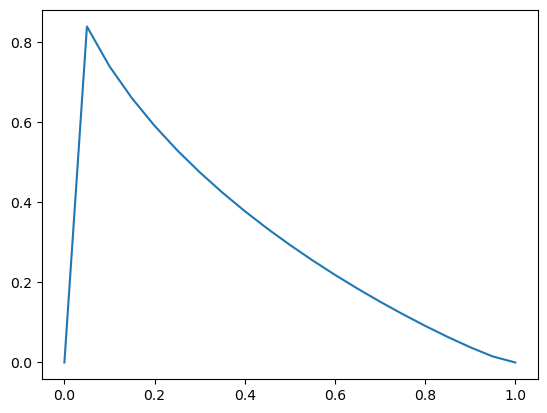

In [550]:
plt.plot(np.linspace(0,1,21), [estimate_capacity(bin_asym_channel(0.01, (err - 0.01) % 1))[0] for err in np.linspace(0,1,21)])

In [555]:
estimate_capacity(bin_asym_channel(0.01, 0))

(0.9597723596885699, array([0.49077425, 0.50922575]))

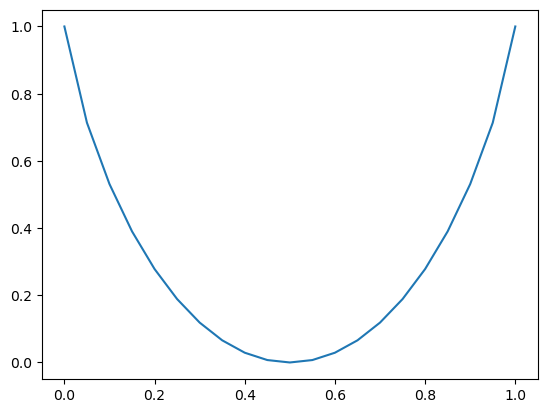

In [553]:
plt.plot(np.linspace(0,1,21), [estimate_capacity(single_flip_channel(1, err))[0] for err in np.linspace(0,1,21)])

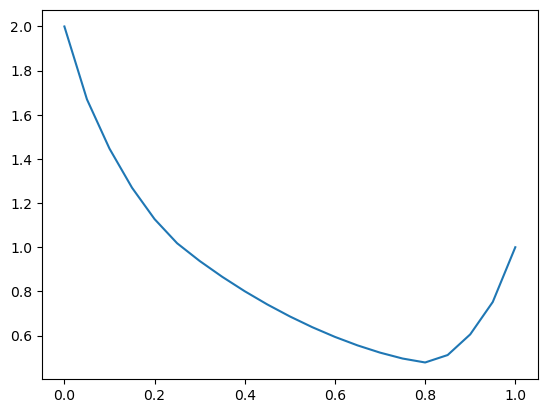

In [554]:
plt.plot(np.linspace(0,1,21), [estimate_capacity(paw_channel(err))[0] for err in np.linspace(0,1,21)])

In [579]:
def final_dist(pW: npt.NDArray[np.float64],
               Q: Callable,
               E: Callable,
               T: int = 1000,
               N: int = 10e3,
               beta: float = 0.01,
               k: int = 4):
    
    """
    Returns MI value of a communication process occurring over the channels specified.
    """
    if pW is None:
        pW = np.array([1/Q.shape[0]]*Q.shape[0])
    else:
        pW = pW
    
    # array true states
    Omega = np.eye(Q.shape[0])

    # Initial States (Row Vectors)
    phi0_arr = E @ Omega
    
    mean_field = ODE(beta=beta, k=k, channel=Q, T=T, t_eval=np.linspace(0, T, int(T/10) + 1))
    
    analytic_curves = []
    
    for row in phi0_arr:
        analytic_curve = mean_field(initial_state=row/N)
        analytic_curves.append(analytic_curve)
    
    phi_t = []
    for curve in analytic_curves:
        final_message = curve.y.T[-1]
        phi_n = final_message/np.sum(final_message)
        phi_t.append(phi_n)
        
    return -1 * mutual_info(np.stack(phi_t), pW)

In [580]:
final_dist(pW=np.array([1/2,1/2]), Q=single_flip_channel(1,eps), E=single_flip_channel(1,dlt))

-1.1031591999789742e-16

In [581]:
def estimate_spreading_capacity(
               Q: Callable,
               E: Callable,
               T: int = 1000,
               N: int = 10e3,
               beta: float = 0.01,
               k: int = 4):
    
    # Initial guess for input distribution P(X)
    px0 = np.array([1/Q.shape[0]]*Q.shape[0])  

    # Constraints: probabilities must sum to 1
    constraints = ({'type': 'eq', 'fun': lambda px: np.sum(px) - 1})

    # Bounds: each probability must be between 0 and 1
    bounds = [(0, 1)]*Q.shape[0]

    # Optimize to find the input distribution that maximizes mutual information
    result = minimize(final_dist, px0, args=(Q, E, T, N, beta, k), bounds=bounds, constraints=constraints, method='SLSQP')

    # Channel capacity is the negative of the minimized result
    channel_capacity = -result.fun
    optimal_px = result.x

    return channel_capacity, optimal_px

In [583]:
estimate_spreading_capacity(Q=single_flip_channel(1,0.01), E=single_flip_channel(1,0.001))

(0.5810921765602299, array([0.5, 0.5]))

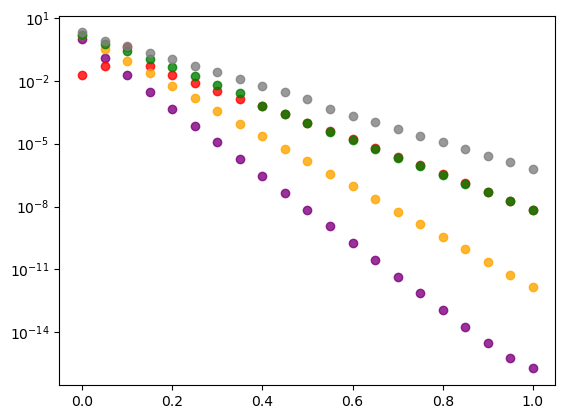

In [888]:
plt.plot(np.linspace(0,1,21), 
         [estimate_spreading_capacity(Q=single_flip_channel(1,err), 
                                      E=single_flip_channel(1,0.001))[0] for err in np.linspace(0,1,21)], 'o',
         color='purple', alpha=0.8)
plt.plot(np.linspace(0,1,21), # This should be 0.1
         [estimate_spreading_capacity(Q=bin_asym_channel(0.1,np.abs(0.1 - err)), 
                                      E=single_flip_channel(1,0.001))[0] for err in np.linspace(0,1,21)], 'o',
         color='red', alpha=0.8)
plt.plot(np.linspace(0,1,21), 
         [estimate_spreading_capacity(Q=simplex_channel(3,err), 
                                      E=simplex_channel(3,0.001))[0] for err in np.linspace(0,1,21)], 'o',
         color='orange', alpha=0.8)
plt.plot(np.linspace(0,1,21), 
         [estimate_spreading_capacity(Q=star_channel(3,err), 
                                      E=simplex_channel(3,0.001))[0] for err in np.linspace(0,1,21)], 'o',
         color='green', alpha=0.8)
plt.plot(np.linspace(0,1,21), 
         [estimate_spreading_capacity(Q=paw_channel(err), 
                                      E=simplex_channel(4,0.001))[0] for err in np.linspace(0,1,21)], 'o',
         color='grey', alpha=0.8)

plt.yscale('log')

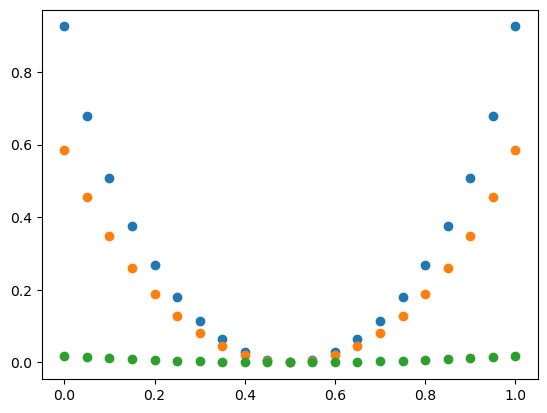

In [856]:
plt.plot(np.linspace(0,1,21), 
         [estimate_spreading_capacity(Q=single_flip_channel(1,0.001), 
                                      E=single_flip_channel(1,err))[0] for err in np.linspace(0,1,21)], 'o')
plt.plot(np.linspace(0,1,21), 
         [estimate_spreading_capacity(Q=single_flip_channel(1,0.01), 
                                      E=single_flip_channel(1,err))[0] for err in np.linspace(0,1,21)], 'o')
plt.plot(np.linspace(0,1,21), 
         [estimate_spreading_capacity(Q=single_flip_channel(1,0.1), 
                                      E=single_flip_channel(1,err))[0] for err in np.linspace(0,1,21)], 'o')


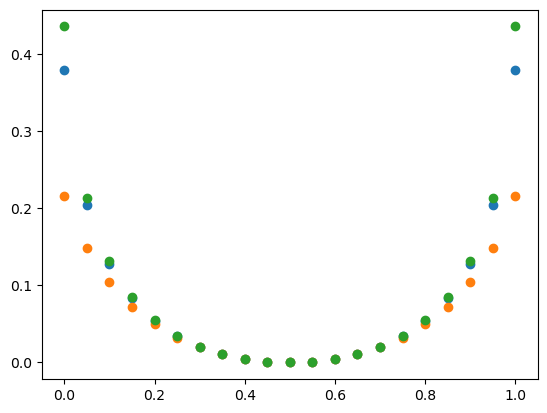

In [858]:
plt.plot(np.linspace(0,1,21), 
         [estimate_spreading_capacity(Q=bin_asym_channel(0.001,(0.1 - 0.001) % 1), 
                                      E=single_flip_channel(1,err))[0] for err in np.linspace(0,1,21)], 'o')
plt.plot(np.linspace(0,1,21), 
         [estimate_spreading_capacity(Q=bin_asym_channel(0.01,(0.1 - 0.01) % 1), 
                                      E=single_flip_channel(1,err))[0] for err in np.linspace(0,1,21)], 'o')
plt.plot(np.linspace(0,1,21), 
         [estimate_spreading_capacity(Q=bin_asym_channel(0.1,(0.1 - 0.1) % 1), 
                                      E=single_flip_channel(1,err))[0] for err in np.linspace(0,1,21)], 'o')


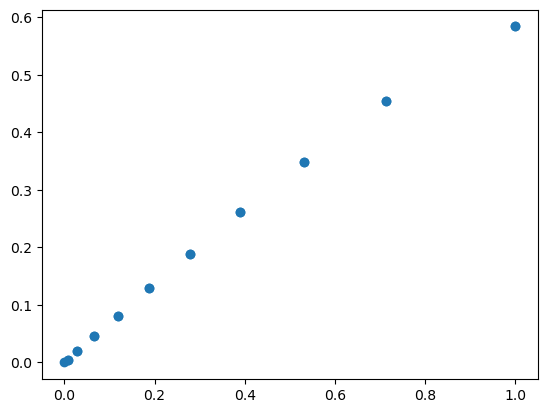

In [739]:
plt.plot([mutual_info(single_flip_channel(1,err), np.array([1/2,1/2])) for err in np.linspace(0,1,21)], 
         [estimate_spreading_capacity(Q=single_flip_channel(1,0.01), 
                                      E=single_flip_channel(1,err))[0] for err in np.linspace(0,1,21)], 'o')

In [ ]:
# Larger Population

In [593]:
resolution = 100
num_runs = 100

X1 = np.array([1, 0])
X2 = np.array([0, 1])

MI_phi = []
MI_sim = []



for err in np.linspace(0, 1, resolution + 1):

    channel = single_flip_channel(1, err)

    initial_state_x1 = X1
    initial_state_x2 = X2
    
    # Gillespie
    # Noisy Gillespie Algorithm
    runs_x1 = list()
    for _ in tqdm(range(num_runs)):

        sim_x1 = NoisyGillespie(N=N, initial_state=initial_state_x1, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x1.simulate(max_time=T, density=True)
        runs_x1.append((test_sim[0], test_sim[1]))
        
    runs_x2 = list()
    for _ in tqdm(range(num_runs)):

        sim_x2 = NoisyGillespie(N=N, initial_state=initial_state_x2, beta=beta, k=k, 
                            channel=channel)
        test_sim = sim_x2.simulate(max_time=T, density=True)
        runs_x2.append((test_sim[0], test_sim[1]))

    # Interpolating Gillespie Means
    MI_sim_runs = []
    
    common_time = np.linspace(0, T, T+1)
    #interpolated_values_x1 = []
    #interpolated_values_x2 = []
#
    #for run_t, run_y in runs_x1:
    #    interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
    #    interpolated_values_x1.append(interp_func(common_time))
    #for run_t, run_y in runs_x2:
    #    interp_func = interp1d(run_t, run_y, kind='linear', fill_value='extrapolate', axis=0) 
    #    interpolated_values_x2.append(interp_func(common_time))
#
    #interp_sim_arr_x1 = np.array(interpolated_values_x1)
    #interp_sim_arr_x2 = np.array(interpolated_values_x2)
#
    #for arr1, arr2 in tqdm(zip(interp_sim_arr_x1, interp_sim_arr_x2)):
    #    sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
    #    sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
    #    MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
    
    for arr1, arr2 in tqdm(zip([tup[1] for tup in runs_x1], [tup[1] for tup in runs_x2])):
        sim_phi_x1 = arr1[-1]/np.sum(arr1[-1])
        sim_phi_x2 = arr2[-1]/np.sum(arr2[-1])
        MI_sim_runs.append(mutual_info(np.stack([sim_phi_x1, sim_phi_x2]), X))
        
    MI_se = np.std(np.array(MI_sim_runs)) / np.sqrt(num_runs)
    MI_conf_int = 1.96 * MI_se
    
    MI_sim_means = np.mean(np.array(MI_sim_runs))
    
    #MI_sim_lower = MI_sim_means - MI_conf_int
    #MI_sim_higher = MI_sim_means + MI_conf_int

    #MI_sim_lower = np.clip(MI_sim_lower, 0, 1)
    #MI_sim_higher = np.clip(MI_sim_higher, 0, 1)

    # Mean Field    
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T, t_eval=common_time)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2]), X))
    MI_sim.append((MI_sim_means, MI_conf_int))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
with open('/data_users1/sagar/modeling-info-spread/pickles/')

In [679]:
    
X1 = np.array([1, 0, 0])
X2 = np.array([0, 1, 0])
X3 = np.array([0, 0, 1])

MI_phi = []
MI_sim = []
capacities = []



for err in np.linspace(0, 1, resolution + 1):

    channel = simplex_channel(3, err)

    initial_state_x1 = X1
    initial_state_x2 = X2
    initial_state_x3 = X3

    common_time = np.linspace(0, T, T+1)
    mean_field = ODE(beta=beta, k=k, channel=channel, T=T, t_eval=common_time)
    analytic_curve_x1 = mean_field(initial_state=initial_state_x1/N)
    analytic_curve_x2 = mean_field(initial_state=initial_state_x2/N)
    analytic_curve_x3 = mean_field(initial_state=initial_state_x3/N)

    M1 = analytic_curve_x1.y.T
    M2 = analytic_curve_x2.y.T
    M3 = analytic_curve_x3.y.T
    
    
    last_phi_x1 = M1[-1]/np.sum(M1[-1])
    last_phi_x2 = M2[-1]/np.sum(M2[-1])
    last_phi_x3 = M3[-1]/np.sum(M3[-1])
    
    # for t in M1... MI_phi.apped
    
    MI_phi.append(mutual_info(np.stack([last_phi_x1, last_phi_x2, last_phi_x3]), np.array([1/3,1/3,1/3])))
    MI_sim.append((MI_sim_means, MI_conf_int))
    capacities.append(estimate_capacity(channel))
    

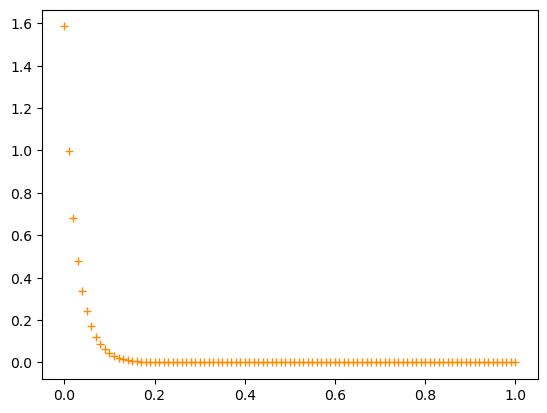

In [680]:
plt.plot(np.linspace(0,1,101), MI_phi, '+', color='darkorange')
#plt.errorbar(x=capacities, y=[tup[0] for tup in MI_sim], yerr=[tup[1] for tup in MI_sim], marker='.',
#            linestyle='none', color='indigo', ecolor='darkviolet')

In [681]:
def exponential_decay(x, a, b):
    return a * np.exp(b * x)

In [682]:
params, covariance = curve_fit(exponential_decay, np.linspace(0,1,101), MI_phi)

In [683]:
a,b = params
a, b

(1.5466872092832495, -38.90685804919356)

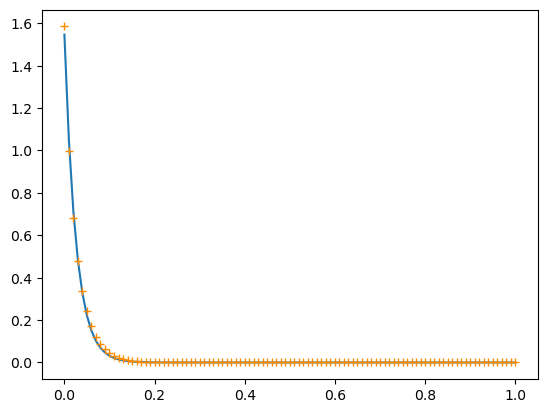

In [684]:
plt.plot(np.linspace(0,1,101), exponential_decay(np.linspace(0,1,101), a, b))
plt.plot(np.linspace(0,1,101), MI_phi, '+', color='darkorange')

In [655]:
# Plots have to be of information entered in the system and capacity of Q

In [ ]:
# if we add another other options for the propensities, perhaps we can get recover the other models

In [743]:
mutual_info(single_flip_channel(1, 0.5), np.array([0.8, 0.2]))

0.0